In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!git config --global user.name "alistvt"
!git config --global user.email "alistvt@gmail.com"

%cd /content/drive/MyDrive/multidoc-conv-qa/src/retriever

/content/drive/MyDrive/multidoc-conv-qa/src/retriever


In [3]:
!pip install -r ../../requirements.txt --quiet
!pip install --quiet transformers datasets accelerate

     |████████████████████████████████| 3.8 MB 14.6 MB/s 
     |████████████████████████████████| 76 kB 5.7 MB/s 
     |████████████████████████████████| 5.8 MB 20.5 MB/s 
     |████████████████████████████████| 325 kB 79.2 MB/s 
     |████████████████████████████████| 10.6 MB 60.2 MB/s 
     |████████████████████████████████| 159 kB 79.8 MB/s 
     |████████████████████████████████| 680 kB 77.0 MB/s 
     |████████████████████████████████| 1.2 MB 63.1 MB/s 
     |████████████████████████████████| 255 kB 64.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 880 kB 63.0 MB/s 
     |████████████████████████████████| 7.6 MB 63.4 MB/s 
     |████████████████████████████████| 182 kB 78.1 MB/s 
     |████████████████████████████████| 212 kB 83.6 MB/s 
     |████████████████████████████████| 132 kB 76.2 MB/s 
     |██████████████

# Document Retrival with Follow up Detector (DR.FUD) + DR. TEIT

In this method we use a FCN to detect wheter a question is a follow up of the previous question, meaning that the document is the same of not. If the document is the same, we use the previous answer's document for this question also.

We used LaBSE model for out embeddings. For computing title embedding similarities we used cosine similarity between query embeddings and each document's title embedding.

# Dataset
### Dataset Description

- **mutldoc2dial_doc.json** contains the documents that are indexed by key `domain` and `doc_id` . Each document instance includes the following,

  - `doc_id`: the ID of a document;
  - `title`: the title of the document;
  - `domain`: the domain of the document;
  - `doc_text`: the text content of the document (without HTML markups);
  - `doc_html_ts`: the document content with HTML markups and the annotated spans that are indicated by `text_id` attribute, which corresponds to `id_sp`.
  - `doc_html_raw`: the document content with HTML markups and without span annotations.
  - `spans`: key-value pairs of all spans in the document, with `id_sp` as key. Each span includes the following,
    - `id_sp`: the id of a  span as noted by `text_id` in  `doc_html_ts`;
    - `start_sp`/  `end_sp`: the start/end position of the text span in `doc_text`;
    - `text_sp`: the text content of the span.
    - `id_sec`: the id of the (sub)section (e.g. `<p>`) or title (`<h2>`) that contains the span.
    - `start_sec` / `end_sec`: the start/end position of the (sub)section in `doc_text`.
    - `text_sec`: the text of the (sub)section.
    - `title`: the title of the (sub)section.
    - `parent_titles`: the parent titles of the `title`.

- **multidoc2dial_dial_train.json** and **multidoc2dial_dial_validation.json**  contain the training and dev split of dialogue data that are indexed by key `domain` . Please note: **For test split, we only include a dummy file in this version.**

  Each dialogue instance includes the following,

  - `dial_id`: the ID of a dialogue;
  - `turns`: a list of dialogue turns. Each turn includes,
    - `turn_id`: the time order of the turn;
    - `role`: either "agent" or "user";READ
    - `da`: dialogue act;
    - `references`: a list of spans with `id_sp` ,  `label` and `doc_id`. `references` is empty if a turn is for indicating previous user query not answerable or irrelevant to the document. **Note** that labels "*precondition*"/"*solution*" are fuzzy annotations that indicate whether a span is for describing a conditional context or a solution.
    - `utterance`: the human-generated utterance based on the dialogue scene.
Downloading the training dataset:

In [2]:
import json
with open('../../dataset/multidoc2dial/v1.0/multidoc2dial_doc.json', 'r') as f:
    multidoc2dial_doc = json.load(f)

#### Extracting titles

In [3]:
titles = []
for doc_idx1 in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][doc_idx1]:
        titles.append(doc_idx2)

#### Extracting document texts

In [4]:
doc_texts_train = []
title_to_domain = {}
for doc_idx1 in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][doc_idx1]:
        doc_texts_train.append(multidoc2dial_doc['doc_data'][doc_idx1]\
                                          [doc_idx2]['doc_text'].strip())
        title_to_domain[doc_idx2] = doc_idx1

## Encoding the sentences
We use the LaBSE which is a Language-agnostic BERT Sentence Encoder (LaBSE) is a BERT-based model trained for sentence embedding for 109 languages. The pre-training process combines masked language modeling with translation language modeling. The model is useful for getting multilingual sentence embeddings and for bi-text retrieval.

In [5]:
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import numpy as np
import torch
from torch.nn.functional import normalize

from tqdm import tqdm

model_name = "setu4993/LaBSE"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

### `get_embeddings`
In this method we extract the **pooler output** (Last layer hidden-state of the first token of the sequence (classification token) after further processing through the layers used for the auxiliary pretraining task. E.g. for BERT-family of models, this returns the classification token after processing through a linear layer and a tanh activation function. The linear layer weights are trained from the next sentence prediction (classification) objective during pretraining).

In [6]:
def get_embeddings(sentece):
    """
    Return embeddings based on encoder model

    :param sentence: input sentence(s)
    :type sentence: str or list of strs
    :return: embeddings
    """
    tokenized = tokenizer(sentece,
                                return_tensors="pt",
                                padding=True)
    with torch.no_grad():
        embeddings = model(**tokenized)
    
    return np.squeeze(np.array(embeddings.pooler_output))

### Title embedding

In [7]:
import os
title_embeddings_file = 'doc_title_LaBSE_Embedding.npy'

if not os.path.exists(title_embeddings_file):
    title_embeddings = []
    for title in tqdm(titles):
        title_embeddings.append(get_embeddings(title))

    with open(title_embeddings_file, 'wb') as f:
        np.save(f, np.array(title_embeddings))
else:
    title_embeddings = np.load(title_embeddings_file)
    title_embeddings = list(title_embeddings)


In [8]:
import pickle
title_to_embeddings_file = 'title_to_embeddings.pkl'

if not os.path.exists(title_to_embeddings_file):
    title_to_embeddings = {}
    for title in tqdm(titles):
        title_to_embeddings[title] = get_embeddings(title)
    with open(title_to_embeddings_file, 'wb') as f:
        pickle.dump(title_to_embeddings, f)
else:
    with open(title_to_embeddings_file, 'rb') as f:
        title_to_embeddings = pickle.load(f)

## Calculating the IDF for each token

In [9]:
words_idf_file = 'IDFs.pkl'
N_doc = len(doc_texts_train)

if not os.path.exists(words_idf_file):
    # First getting all distinct words in all documents
    words = set()
    doc_texts_train_tokenized = []
    for doc in tqdm(doc_texts_train, desc="getting all words from documents"):
        tokenized_doc = [s.lower() for s in tokenizer.tokenize(doc)]
        doc_texts_train_tokenized.append(tokenized_doc) 
        words = set(tokenized_doc).union(words)

    # calculating each word IDF
    words2IDF = {}
    for word in tqdm(words, desc="calculating words IDF scores"):
        n_word = 0
        for doc in doc_texts_train_tokenized:
            if word in doc:
                n_word += 1
        words2IDF[word] = np.log(N_doc / (n_word + 1))

    with open(words_idf_file, 'wb') as f:
        pickle.dump(words2IDF, f)

else:
    with open(words_idf_file, 'rb') as f:
        words2IDF = pickle.load(f)

In [10]:
len(words2IDF)

8446

In [11]:
def calc_idf_score(sentence):
    """
    Calculate the mean idf score for given sentence.
    (used to understand the contribution of the knowledge of each question
    questions with high frequent words are meaningless and we can ignore them
    roughly, which is done by this score.)

    :param sentence: input sentence
    :type sentence: str
    :return: mean idf score of sentence token
    """
    tokenzied_sentence = [s.lower() for s in tokenizer.tokenize(sentence)]
    score = 0
    for token in tokenzied_sentence:
        if token in words2IDF:
            score += words2IDF[token]
        else:
            score += np.log(N_doc)
    return score / len(tokenzied_sentence) if len(tokenzied_sentence) else 0

## Constructing the Follow-up Dataset

``` history | question | is_follow_up```

is_follow_up: shows that the history's document is the same as the current question's.

In [53]:
def combine_sentences(s1, s2):
    separation_token = " <SEP> "
    return s1 + separation_token + s2


def construct_followup_dataset(filepath):
    import json
    with open(filepath, 'r') as f:
        multidoc2dial_dial_train = json.load(f)
    
    historys = []
    questions = []
    combined = []
    labels = []
    prev_docs = []
    current_docs = []
    prev_answers = []
    dial_ids = []
    turn_ids = []
    domains = []

    for domain in multidoc2dial_dial_train['dial_data']:
        for dial in multidoc2dial_dial_train['dial_data'][domain]:
            prev_doc = ''
            prev_question = ''
            prev_answer = ''
            for turn in dial['turns']:
                if turn['role'] == "user":
                    current_question = turn['utterance']
                    historys.append(prev_question)
                    questions.append(current_question)
                    
                    dial_ids.append(dial['dial_id'])
                    turn_ids.append(turn['turn_id'])
                    domains.append(domain)

                    combined.append(combine_sentences(prev_question, current_question))

                    current_doc = turn['references'][0]['doc_id']
                    labels.append(int(current_doc==prev_doc))

                    prev_docs.append(prev_doc)
                    current_docs.append(current_doc)
                    prev_answers.append(prev_answer)

                    prev_doc, prev_question = current_doc, current_question
                else:
                    prev_answer = turn['utterance']
                    
    return dial_ids, turn_ids, domains, historys, questions, combined, labels, prev_docs, current_docs, prev_answers

In [54]:
import pandas as pd

train_dial_ids, train_turn_ids, train_domains, train_history, train_questions, train_combined, train_labels, train_prev_docs, train_current_docs, train_prev_answers = construct_followup_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_train.json')
test_dial_ids, test_turn_ids, test_domains, test_history, test_questions, test_combined, test_labels, test_prev_docs, test_current_docs, test_prev_answers = construct_followup_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_validation.json')

train_dict_dataset = {"domain": train_domains, "turn_id": train_turn_ids, "dial_id": train_dial_ids, "history":train_history, "question": train_questions, "combined": train_combined, "followup": train_labels, "prev_doc": train_prev_docs, "current_doc": train_current_docs, "prev_answer": train_prev_answers}
test_dict_dataset = {"domain": test_domains, "turn_id": test_turn_ids, "dial_id": test_dial_ids , "history":test_history, "question": test_questions, "combined": test_combined, "followup": test_labels, "prev_doc": test_prev_docs, "current_doc": test_current_docs, "prev_answer": test_prev_answers}

train_df = pd.DataFrame(train_dict_dataset)
test_df = pd.DataFrame(test_dict_dataset)

In [55]:
test_df

,domain,turn_id,dial_id,history,question,combined,followup,prev_doc,current_doc,prev_answer
0,dmv,1,1409501a35697e0ce68561e29577b90a,,My insurance ended so what should i do,<SEP> My insurance ended so what should i do,0,,Top 5 DMV Mistakes and How to Avoid Them#3_0,
1,dmv,3,1409501a35697e0ce68561e29577b90a,My insurance ended so what should i do,Don't do that I'll get insurance,My insurance ended so what should i do <SEP> D...,1,Top 5 DMV Mistakes and How to Avoid Them#3_0,Top 5 DMV Mistakes and How to Avoid Them#3_0,You will need to get insurance or we will susp...
2,dmv,5,1409501a35697e0ce68561e29577b90a,Don't do that I'll get insurance,"I have, that is why I am here to clear that up...","Don't do that I'll get insurance <SEP> I have,...",1,Top 5 DMV Mistakes and How to Avoid Them#3_0,Top 5 DMV Mistakes and How to Avoid Them#3_0,"Okay, have you received a letter from the DMV ..."
3,dmv,7,1409501a35697e0ce68561e29577b90a,"I have, that is why I am here to clear that up...",Thank you so much. After looking through these...,"I have, that is why I am here to clear that up...",0,Top 5 DMV Mistakes and How to Avoid Them#3_0,Help finding enough proof of ID#3_0,"Okay, we can take care of that"
4,dmv,9,1409501a35697e0ce68561e29577b90a,Thank you so much. After looking through these...,"Great. I think that I can found some bills, of...",Thank you so much. After looking through these...,1,Help finding enough proof of ID#3_0,Help finding enough proof of ID#3_0,"Sure, it is. You can contact your college and ..."
...,...,...,...,...,...,...,...,...,...,...
4491,studentaid,4,79f50cd4082141a57479195c61a0e7fc,"If I am totally and permanently disabled, can ...",In this case I would not like,"If I am totally and permanently disabled, can ...",1,Total and Permanent Disability Discharge | Fed...,Total and Permanent Disability Discharge | Fed...,want to qualify for a TPD download?
4492,studentaid,6,79f50cd4082141a57479195c61a0e7fc,In this case I would not like,If I am a veteran whose application for discha...,In this case I would not like <SEP> If I am a ...,1,Total and Permanent Disability Discharge | Fed...,Total and Permanent Disability Discharge | Fed...,"Unfortunately, no relevant information is found."
4493,studentaid,8,79f50cd4082141a57479195c61a0e7fc,If I am a veteran whose application for discha...,"In addition, I need to learn about PSLF. What ...",If I am a veteran whose application for discha...,0,Total and Permanent Disability Discharge | Fed...,Public Service Loan Forgiveness | Federal Stud...,in this case it is not subject to a post-disch...
4494,studentaid,10,79f50cd4082141a57479195c61a0e7fc,"In addition, I need to learn about PSLF. What ...",null,"In addition, I need to learn about PSLF. What ...",1,Public Service Loan Forgiveness | Federal Stud...,Public Service Loan Forgiveness | Federal Stud...,"Are you employed by a U.S. federal, state, loc..."


In [16]:
max([len(x["combined"].split()) for _, x in test_df.iterrows()])

74

In [ ]:
train_df

,history,question,combined,followup,prev_doc,current_doc,prev_answer
0,,"Hello, I forgot o update my address, can you h...","<SEP> Hello, I forgot o update my address, ca...",0,,Top 5 DMV Mistakes and How to Avoid Them#3_0,
1,"Hello, I forgot o update my address, can you h...",Can I do my DMV transactions online?,"Hello, I forgot o update my address, can you h...",1,Top 5 DMV Mistakes and How to Avoid Them#3_0,Top 5 DMV Mistakes and How to Avoid Them#3_0,"hi, you have to report any change of address t..."
2,Can I do my DMV transactions online?,You've got it. Another query about DMV. What h...,Can I do my DMV transactions online? <SEP> You...,0,Top 5 DMV Mistakes and How to Avoid Them#3_0,Registration suspensions for failure to pay to...,"Yes, you can sign up for MyDMV for all the onl..."
3,You've got it. Another query about DMV. What h...,"Besides that, will I receive a notice?",You've got it. Another query about DMV. What h...,1,Registration suspensions for failure to pay to...,Registration suspensions for failure to pay to...,the suspension is placed on hold pending the o...
4,"Besides that, will I receive a notice?",If you submit the affidavit?,"Besides that, will I receive a notice? <SEP> I...",1,Registration suspensions for failure to pay to...,Registration suspensions for failure to pay to...,"the NYS Department of Motor Vehicles , "" DMV ..."
...,...,...,...,...,...,...,...
23394,"By the way, who can I contact to give me infor...",What if I've fallen behind on one or more loan...,"By the way, who can I contact to give me infor...",0,Loan Servicers | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0,Your school's financial aid office must have t...
23395,What if I've fallen behind on one or more loan...,I have another question regarding the Military...,What if I've fallen behind on one or more loan...,0,Student Loan Repayment | Federal Student Aid#1_0,Student Loan Deferment | Federal Student Aid#1_0,One thing you definitely want to avoid is goin...
23396,I have another question regarding the Military...,something else I want to ask about FAFSA. What...,I have another question regarding the Military...,0,Student Loan Deferment | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0,You will have to complete the Military Service...
23397,something else I want to ask about FAFSA. What...,How can I make a payment by post?,something else I want to ask about FAFSA. What...,1,Student Loan Repayment | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0,contact your loan servicer to find out your op...


In [12]:
def tokenize_function(examples, prediction=False, cuda=False):
    if prediction:
        tokenized = tokenizer(examples['combined'], max_length=128, padding="max_length", truncation=True, return_tensors='pt')
    else:
        tokenized = tokenizer(examples['combined'], max_length=128, padding="max_length", truncation=True)
    if cuda:
        tokenized_cuda = {}
        for key, value in tokenized.items():
            tokenized_cuda[key] = value.cuda()
        return tokenized_cuda
    else:
        return tokenized

### constructing dataloader

In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenized_trainset = train_dataset.map(tokenize_function, batched=True)
tokenized_testset = test_dataset.map(tokenize_function, batched=True)

tokenized_trainset = tokenized_trainset.rename_column("followup", "label")
tokenized_testset = tokenized_testset.rename_column("followup", "label")

fud_dataset = DatasetDict()

fud_dataset['train'] = tokenized_trainset
fud_dataset['validation'] = tokenized_testset


  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

# Methods

## FCN based on [cls]

### AutoModelForSequenceClassification

We use a classification method on the questions to decide the relationship between the previous question and current question.
In the dataset provided to us, previous turn documents are predefined, meaning that we are aware of the previous documents, therefore, if the prediction predicts that current question's document is the same as the previous, we don't need to retrieve a document and we give the previous doc_id.

#### model

In [ ]:
model_name = "setu4993/LaBSE"

tokenizer = AutoTokenizer.from_pretrained(model_name)
fudnet_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cuda:0")
fudnet_model.to(device)

#### metrics

In [18]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### train

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='/home/',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy ='epoch',
    load_best_model_at_end=True,
    # auto_find_batch_size=True,
)

trainer = Trainer(
    model=fudnet_model,
    args=training_args,
    train_dataset=fud_dataset['train'],
    eval_dataset=fud_dataset['validation'],
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: combined, current_doc, prev_answer, history, question, prev_doc. If combined, current_doc, prev_answer, history, question, prev_doc are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 23399
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1464


Epoch,Training Loss,Validation Loss,Accuracy
1,0.172100,0.144127,0.949066
2,0.094800,0.137107,0.954404


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: combined, current_doc, prev_answer, history, question, prev_doc. If combined, current_doc, prev_answer, history, question, prev_doc are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4496
  Batch size = 32
Saving model checkpoint to /home/checkpoint-732
Configuration saved in /home/checkpoint-732/config.json
Model weights saved in /home/checkpoint-732/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: combined, current_doc, prev_answer, history, question, prev_doc. If combined, current_doc, prev_answer, history, question, prev_doc are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Run

TrainOutput(global_step=1464, training_loss=0.1559999535481135, metrics={'train_runtime': 779.0272, 'train_samples_per_second': 60.072, 'train_steps_per_second': 1.879, 'total_flos': 3078267792184320.0, 'train_loss': 0.1559999535481135, 'epoch': 2.0})

In [13]:
tokenizer_fudnet = tokenizer
fudnet_model = AutoModelForSequenceClassification.from_pretrained('alistvt/fudnet')

In [14]:
device = torch.device("cuda:0")
fudnet_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(501153, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### DR. TEIT*

In this method we used two scoring measure and aggregate them by a convex combination as below:
$$
λ*Similiarity_{Title Embedding} + (1-λ)*Similiarity_{TextIDF}
$$

We used LaBSE model for our embeddings. For computing title embedding similarities we used cosine similarity between query embeddings and each document's title embedding.

For the second part we used character-level (2gram to 8gram). We also trained our TF-IDF transformation matrix on the Multidoc2dial2022 documnets.

**NOTE: In `predict_DR_TEIT` you may see a diffrent notation (`alpha`) but they are the same.**

#### TF-IDF Transformation Matrix Fitting

In [43]:
doc_texts_train = []
doc_idx_train = []

doc_domains = {}
# for domain, domain_data in multidoc2dial_doc['doc_data'].items():
#     for doc_id, doc_data in domain_data.items():
#         processed_section_ids = []
#         for span_id, span in doc_data['spans'].items():
#             if span['id_sec'] not in processed_section_ids:
#                 processed_section_ids.append(span['id_sec'])
#                 section_text = span['text_sec']
#                 doc_texts_train.append(section_text)
#                 doc_idx_train.append(doc_id)

for domain in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][domain]:
        doc_texts_train.append(multidoc2dial_doc['doc_data'][domain]\
                                          [doc_idx2]['doc_text'].strip())
        doc_idx_train.append(doc_idx2)
        doc_domains[doc_idx2] = domain

In [16]:
print(len(doc_texts_train), len(doc_idx_train))

488 488


#### Stopwords removal and preprocessing

In [23]:
from gensim.parsing.preprocessing import STOPWORDS
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

new_doc_texts_train = []

all_stopwords_gensim = STOPWORDS.union(set(['likes', 'play']))

for text in tqdm(doc_texts_train):
    text = text.lower()
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords_gensim]
    new_doc_texts_train.append(" ".join(tokens_without_sw))

# print(tokens_without_sw)
doc_texts_train = new_doc_texts_train

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 488/488 [00:04<00:00, 101.97it/s]


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(strip_accents=None,
                                 analyzer='char_wb',
                                 ngram_range=(3, 6),
                                 norm='l2',
                                 use_idf=True,
                                 smooth_idf=True)
tfidf_wm = tfidfVectorizer.fit_transform(doc_texts_train)

In [50]:
len(tfidfVectorizer.get_feature_names_out())

8398

In [21]:
import pickle
with open('tfidfVectorizer.pkl', 'wb') as f:
    pickle.dump(tfidfVectorizer, f)

with open('tfidf_wm.pkl', 'wb') as f:
    pickle.dump(tfidf_wm, f)

#### DR. TEIT

the input is consisted of a list of queries, which is the current question and its history turns.
for each of the questions, we compute two similarity score for each of our documents, one of them is based on the pretrained LM and the other on is based on character level matching. Both of these scores will be weighted by a coefficient which is the `idf_score` of the query, defining how much meaning does the query contain. Then these scores will be summed up in a convex manner and the final matching score with all documents is computed. We return the result by sorting these scores.

In [ ]:
# def predict_DR_TEIT(queries, k=1, alpha=10):
#     """
#     Predict which document is matched to the given query.

#     :param queries: input queries in time reversed order (latest first)
#     :type queries: str (or list of strs)
#     :param k: number of returning docs
#     :type k: int 
#     :return: return the document names and accuracies
#     """

#     idf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
#     tfidf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
#     coef_sum = 0
#     for i, query in enumerate(queries):
#         query_embd = get_embeddings(query)
#         query_sim = list(map(lambda x: np.dot(x, query_embd) /
#                             (np.linalg.norm(query_embd) * np.linalg.norm(x)),
#                             title_embeddings))
#         query_sim = np.array(query_sim)
#         coef = 2**(-i) * calc_idf_score(query)
#         coef = calc_idf_score(query)
#         coef_sum += coef

#         idf_score += coef * query_sim
#         tfidf_score += coef * np.squeeze(np.asarray(tfidf_wm @ tfidfVectorizer.transform([query]).todense().T))

#     scores = (idf_score + alpha * tfidf_score) / coef_sum
#     best_k_idx = scores.argsort()[::-1][:k]
#     scores = scores[best_k_idx]
#     predictions = list(map(lambda x: titles[x], best_k_idx))
#     return (scores, predictions)

In [41]:
def predict_DR_TEIT(queries, k=1, alpha=10):
    """
    Predict which document is matched to the given query.

    :param queries: input queries in time reversed order (latest first)
    :type queries: str (or list of strs)
    :param k: number of returning docs
    :type k: int 
    :return: return the document names and accuracies
    """

    idf_score = np.array(list(map(lambda x: 0.0, doc_idx_train)))
    # idf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    tfidf_score = np.array(list(map(lambda x: 0.0, doc_idx_train)))
    # tfidf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    coef_sum = 0
    for i, query in enumerate(queries):
        # query_embd = get_embeddings(query)
        # query_sim = list(map(lambda x: np.dot(x, query_embd) /
        #                     (np.linalg.norm(query_embd) * np.linalg.norm(x)),
        #                     title_embeddings))
        # query_sim = np.array(query_sim)
        # coef = 2**(-i) * calc_idf_score(query)
        coef = calc_idf_score(query)
        coef_sum += coef

        # idf_score += coef * query_sim
        tfidf_score += coef * np.squeeze(np.asarray(tfidf_wm @ tfidfVectorizer.transform([query]).todense().T))

    scores = (tfidf_score) / coef_sum
    best_k_idx = scores.argsort()[::-1][:k]
    scores = scores[best_k_idx]
    predictions = list(map(lambda x: doc_idx_train[x], best_k_idx))
    # predictions = list(map(lambda x: titles[x], best_k_idx))
    return (scores, predictions)

### FUDNet + DR. TEIT

In [34]:
def predict_FUDNet_DR_TEIT(data, k=1):
    inputs = tokenize_function(data, prediction=True, cuda=True)
    outputs = fudnet_model(**inputs)
    is_followup = bool(torch.argmax(outputs.logits))
    
    if is_followup:
        dr_scores, dr_predictions = predict_DR_TEIT([data['prev_answer'], data['question'], data['history']], k=k)
        return dr_predictions
    else:
        dr_scores, dr_predictions = predict_DR_TEIT([data['question']], k=k)
        return dr_predictions

In [ ]:
test_df.loc[2]

history                         Don't do that I'll get insurance
question       I have, that is why I am here to clear that up...
combined       Don't do that I'll get insurance <SEP> I have,...
followup                                                       1
prev_doc            Top 5 DMV Mistakes and How to Avoid Them#3_0
current_doc         Top 5 DMV Mistakes and How to Avoid Them#3_0
prev_answer    Okay, have you received a letter from the DMV ...
Name: 2, dtype: object

In [ ]:
predict_FUDNet_DR_TEIT(test_df.loc[2], k=5)

['Top 5 DMV Mistakes and How to Avoid Them#3_0',
 'Respond to DMV insurance letters and orders#3_0',
 'How to change your address#1_0',
 'Insurance lapses#3_0',
 'Information about transaction entries#3_0']

### KNN + FUDNet + DR. TEIT

#### Getting span embeddings

In [27]:
from tqdm import tqdm

def construct_span_doc_id():
    spans = []
    doc_ids = []
    domains = []
    for domain in tqdm(multidoc2dial_doc['doc_data'], desc="iterating over domains"):
        for doc_id in tqdm(multidoc2dial_doc['doc_data'][domain], desc="iterating over doc_ids"):
            doc = multidoc2dial_doc['doc_data'][domain][doc_id]

            spans.append(doc["title"])
            doc_ids.append(doc_id)
            domains.append(domain)
            for span_id, span in doc["spans"].items():
                spans.append(span["text_sp"])
                doc_ids.append(doc_id)
                domains.append(domain)
    assert len(spans) == len(doc_ids) == len(domains), "inconsistency"
    return spans, doc_ids, domains

spans, doc_ids, domains = construct_span_doc_id()

iterating over doc_ids: 100%|██████████| 109/109 [00:00<00:00, 23992.61it/s]

iterating over doc_ids: 100%|██████████| 138/138 [00:00<00:00, 23780.36it/s]

iterating over doc_ids: 100%|██████████| 149/149 [00:00<00:00, 22460.87it/s]

iterating over domains: 100%|██████████| 4/4 [00:00<00:00, 50.92it/s]


In [ ]:
import os
span_embeddings_file = 'span_embeddings_labse.npy'

if not os.path.exists(span_embeddings_file):
    span_embeddings = []
    for span in tqdm(spans):
        span_embeddings.append(get_embeddings(span))

    with open(span_embeddings_file, 'wb') as f:
        np.save(f, np.array(span_embeddings))
else:
    span_embeddings = np.load(span_embeddings_file)
    span_embeddings = list(span_embeddings)

#### Predictor

In [ ]:
def get_nearests_doc_ids(text, k=None):
    x_embed = get_embeddings(text).reshape(1, -1)
    neighs = doc_predictor.kneighbors(x_embed)
    return [doc_ids[x] for x in neighs[1][0,:]]

In [37]:
def predict_KNN_FUDNet_DR_TEIT(queries, k=1, alpha=10):
    """
    Predict which document is matched to the given query.

    :param queries: input queries in time reversed order (latest first)
    :type queries: str (or list of strs)
    :param k: number of returning docs
    :type k: int 
    :return: return the document names and accuracies
    """

    idf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    tfidf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    coef_sum = 0
    for i, query in enumerate(queries):
        query_embd = get_embeddings(query)
        query_sim = list(map(lambda x: np.dot(x, query_embd) /
                            (np.linalg.norm(query_embd) * np.linalg.norm(x)),
                            title_embeddings))
        query_sim = np.array(query_sim)
        # coef = 2**(-i) * calc_idf_score(query)
        coef = calc_idf_score(query)
        coef_sum += coef

        idf_score += coef * query_sim
        tfidf_score += coef * np.squeeze(np.asarray(tfidf_wm @ tfidfVectorizer.transform([query]).todense().T))

    scores = (1 * idf_score + alpha * tfidf_score) / coef_sum
    best_k_idx = scores.argsort()[::-1][:k]
    scores = scores[best_k_idx]
    predictions = list(map(lambda x: titles[x], best_k_idx))
    return (scores, predictions)

def predict_KNN_FUDNet_DR_TEIT(data, k=1):
    inputs = tokenize_function(data, prediction=True, cuda=True)
    outputs = fudnet_model(**inputs)
    is_followup = bool(torch.argmax(outputs.logits))
    
    if is_followup:
        dr_scores, dr_predictions = predict_DR_TEIT([data['prev_answer'], data['question'], data['history']], k=k)
        return dr_predictions
    else:
        dr_scores, dr_predictions = predict_DR_TEIT([data['question']], k=k)
        return dr_predictions

#### Fit knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

doc_predictor = KNeighborsClassifier(n_neighbors=100)
doc_predictor.fit(span_embeddings, doc_ids)

KNeighborsClassifier(n_neighbors=100)

In [ ]:
get_nearests_doc_ids("5 DMV Mistakes")[:5]

['Top 5 DMV Mistakes and How to Avoid Them#3_0',
 'Get a vehicle registration or title record (abstract)#1_0',
 'In-transit vehicle permits (temporary registrations)#3_0',
 'Exchange your out-of-state driver license#1_0',
 'Appeal a TVB ticket conviction#1_0']

# Test
In the test dataset we just picked ones with **user** turn.

In [64]:
def merge_predictions(preds):
    new_preds = []
    for i in preds:
        if i not in new_preds:
            preds.append(i)
    return new_preds

def test_loop(df, predictor):
    prec_at_50 = 0
    prec_at_10 = 0
    prec_at_5 = 0
    prec_at_1 = 0
    ranks = []
    for index, data in tqdm(df.iterrows()):
        predictions = predictor(data, k=100)
        # print(len(predictions))
        # predictions = merge_predictions(predictions)
        actual_doc = data['current_doc']
        drfud_predictions.append({
            'domain': data['domain'],
            'turn_id':data['turn_id'],
            'dial_id':data['dial_id'], 
            'query': data['question'],
            'actual_doc': actual_doc,
            'predictions': predictions[:10]
        })
        # actual_domain = doc_domains[actual_doc]
        # predictions = [p for p in predictions if doc_domains[p]==actual_domain]
        try:
            ranks.append(1 / (predictions.index(actual_doc) + 1))
        except:
            ranks.append(0)
        if actual_doc == predictions[0]:
            prec_at_1 += 1
        if actual_doc in predictions[:5]:
            prec_at_5 += 1
        if actual_doc in predictions[:10]:
            prec_at_10 += 1
        if actual_doc in predictions[:50]:
            prec_at_50 += 1

        if index % 100 == 99:
        # if index % 50 == 49:
            print(f"""
                MRR: mean={np.array(ranks).mean()}, var={np.array(ranks).var()}
                Prec@(1) = {prec_at_1 / index}
                Prec@(5) = {prec_at_5 / index}
                Prec@(10) = {prec_at_10 / index}
                Prec@(50) = {prec_at_50 / index}
                NUMBER_OF_SAMPLES = {index}
            """)

    return f"""
        MRR: mean={np.array(ranks).mean()}, var={np.array(ranks).var()}
        Prec@(1) = {prec_at_1 / index}
        Prec@(5) = {prec_at_5 / index}
        Prec@(10) = {prec_at_10 / index}
        Prec@(50) = {prec_at_50 / index}
        NUMBER_OF_SAMPLES = {index}
    """

In [66]:
import json

drfud_predictions = []
print(test_loop(train_df, predict_FUDNet_DR_TEIT))

with open("drfud_predictions_train.json", 'w') as f:
    json.dump(drfud_predictions, f)

print(test_loop(test_df, predict_FUDNet_DR_TEIT))

drfud_predictions = []
with open("drfud_predictions_test.json", 'w') as f:
    json.dump(drfud_predictions, f)


103it [00:04, 19.01it/s]


                MRR: mean=0.6099460326907136, var=0.15420535612070776
                Prec@(1) = 0.48484848484848486
                Prec@(5) = 0.7575757575757576
                Prec@(10) = 0.9595959595959596
                Prec@(50) = 1.0
                NUMBER_OF_SAMPLES = 99
            


208it [00:08, 39.73it/s]


                MRR: mean=0.7188480863733681, var=0.13624341891854896
                Prec@(1) = 0.6130653266331658
                Prec@(5) = 0.8442211055276382
                Prec@(10) = 0.9447236180904522
                Prec@(50) = 0.9949748743718593
                NUMBER_OF_SAMPLES = 199
            


306it [00:10, 36.09it/s]


                MRR: mean=0.716464658314846, var=0.1327957218302478
                Prec@(1) = 0.5986622073578596
                Prec@(5) = 0.8494983277591973
                Prec@(10) = 0.9364548494983278
                Prec@(50) = 0.9866220735785953
                NUMBER_OF_SAMPLES = 299
            


408it [00:13, 39.69it/s]


                MRR: mean=0.7245200225067268, var=0.1321743968797679
                Prec@(1) = 0.6115288220551378
                Prec@(5) = 0.8521303258145363
                Prec@(10) = 0.9348370927318296
                Prec@(50) = 0.9824561403508771
                NUMBER_OF_SAMPLES = 399
            


505it [00:15, 39.47it/s]


                MRR: mean=0.7284368833407627, var=0.12699738393202273
                Prec@(1) = 0.6072144288577155
                Prec@(5) = 0.8657314629258517
                Prec@(10) = 0.9398797595190381
                Prec@(50) = 0.9859719438877755
                NUMBER_OF_SAMPLES = 499
            


606it [00:18, 37.31it/s]


                MRR: mean=0.7334270326549033, var=0.12659476675871456
                Prec@(1) = 0.6160267111853088
                Prec@(5) = 0.8681135225375626
                Prec@(10) = 0.9398998330550918
                Prec@(50) = 0.986644407345576
                NUMBER_OF_SAMPLES = 599
            


705it [00:21, 38.52it/s]


                MRR: mean=0.7259784178772282, var=0.12917638833134348
                Prec@(1) = 0.6080114449213162
                Prec@(5) = 0.8669527896995708
                Prec@(10) = 0.9370529327610873
                Prec@(50) = 0.9842632331902719
                NUMBER_OF_SAMPLES = 699
            


805it [00:24, 38.40it/s]


                MRR: mean=0.7238244677563361, var=0.1325225780414338
                Prec@(1) = 0.6107634543178974
                Prec@(5) = 0.8585732165206508
                Prec@(10) = 0.9311639549436797
                Prec@(50) = 0.9799749687108886
                NUMBER_OF_SAMPLES = 799
            


906it [00:26, 38.82it/s]


                MRR: mean=0.7233664294738673, var=0.1341296118753345
                Prec@(1) = 0.6129032258064516
                Prec@(5) = 0.8565072302558399
                Prec@(10) = 0.9254727474972191
                Prec@(50) = 0.9766407119021134
                NUMBER_OF_SAMPLES = 899
            


1007it [00:29, 38.24it/s]


                MRR: mean=0.7212364637271474, var=0.1345491578923929
                Prec@(1) = 0.6096096096096096
                Prec@(5) = 0.8578578578578578
                Prec@(10) = 0.923923923923924
                Prec@(50) = 0.973973973973974
                NUMBER_OF_SAMPLES = 999
            


1107it [00:32, 37.23it/s]


                MRR: mean=0.7217546416634442, var=0.1370111041657466
                Prec@(1) = 0.6151046405823476
                Prec@(5) = 0.8516833484986351
                Prec@(10) = 0.916287534121929
                Prec@(50) = 0.9717925386715196
                NUMBER_OF_SAMPLES = 1099
            


1206it [00:34, 37.63it/s]


                MRR: mean=0.7141569229054331, var=0.13795535184765204
                Prec@(1) = 0.603836530442035
                Prec@(5) = 0.8523769808173478
                Prec@(10) = 0.9149291075896581
                Prec@(50) = 0.9724770642201835
                NUMBER_OF_SAMPLES = 1199
            


1305it [00:37, 36.59it/s]


                MRR: mean=0.7196545160770415, var=0.13860429291243762
                Prec@(1) = 0.6143187066974596
                Prec@(5) = 0.850654349499615
                Prec@(10) = 0.9099307159353349
                Prec@(50) = 0.9668976135488837
                NUMBER_OF_SAMPLES = 1299
            


1405it [00:39, 40.35it/s]


                MRR: mean=0.703476467280082, var=0.14217000508613084
                Prec@(1) = 0.5932809149392423
                Prec@(5) = 0.8456040028591851
                Prec@(10) = 0.9027877055039314
                Prec@(50) = 0.9649749821300929
                NUMBER_OF_SAMPLES = 1399
            


1507it [00:42, 38.00it/s]


                MRR: mean=0.6935380371099688, var=0.14416348942486096
                Prec@(1) = 0.5810540360240161
                Prec@(5) = 0.8418945963975984
                Prec@(10) = 0.9026017344896597
                Prec@(50) = 0.961974649766511
                NUMBER_OF_SAMPLES = 1499
            


1604it [00:45, 39.93it/s]


                MRR: mean=0.6988422575654198, var=0.14262446954494593
                Prec@(1) = 0.5866166353971232
                Prec@(5) = 0.8449030644152595
                Prec@(10) = 0.9030644152595372
                Prec@(50) = 0.9631019387116948
                NUMBER_OF_SAMPLES = 1599
            


1707it [00:47, 37.45it/s]


                MRR: mean=0.7030553112105774, var=0.14284821194580732
                Prec@(1) = 0.5938787522071807
                Prec@(5) = 0.8428487345497352
                Prec@(10) = 0.901706886403767
                Prec@(50) = 0.9599764567392584
                NUMBER_OF_SAMPLES = 1699
            


1805it [00:50, 35.47it/s]


                MRR: mean=0.7016355977846782, var=0.14362495531267536
                Prec@(1) = 0.5925514174541412
                Prec@(5) = 0.839355197331851
                Prec@(10) = 0.8977209560867149
                Prec@(50) = 0.9599777654252363
                NUMBER_OF_SAMPLES = 1799
            


1905it [00:53, 40.63it/s]


                MRR: mean=0.6998671697189301, var=0.14446047298782763
                Prec@(1) = 0.5913638757240653
                Prec@(5) = 0.8378093733543971
                Prec@(10) = 0.8967877830437072
                Prec@(50) = 0.9594523433385993
                NUMBER_OF_SAMPLES = 1899
            


2005it [00:55, 37.90it/s]


                MRR: mean=0.6985871903784078, var=0.14435069334898093
                Prec@(1) = 0.5887943971985993
                Prec@(5) = 0.8379189594797398
                Prec@(10) = 0.8959479739869936
                Prec@(50) = 0.959479739869935
                NUMBER_OF_SAMPLES = 1999
            


2104it [00:58, 34.95it/s]


                MRR: mean=0.6945312645123757, var=0.14455184367912183
                Prec@(1) = 0.5821819914244879
                Prec@(5) = 0.837065269175798
                Prec@(10) = 0.8947117675083373
                Prec@(50) = 0.9590281086231539
                NUMBER_OF_SAMPLES = 2099
            


2206it [01:01, 36.86it/s]


                MRR: mean=0.6921398285681184, var=0.14505442631530047
                Prec@(1) = 0.5793542519326966
                Prec@(5) = 0.8353797180536607
                Prec@(10) = 0.8949522510231923
                Prec@(50) = 0.9595270577535243
                NUMBER_OF_SAMPLES = 2199
            


2305it [01:03, 37.19it/s]


                MRR: mean=0.686668129803294, var=0.14609524559400622
                Prec@(1) = 0.5724227925184863
                Prec@(5) = 0.8321009134406263
                Prec@(10) = 0.8929969551979121
                Prec@(50) = 0.9582427142235754
                NUMBER_OF_SAMPLES = 2299
            


2406it [01:06, 30.59it/s]


                MRR: mean=0.6833540807440298, var=0.14603907775276867
                Prec@(1) = 0.5664860358482701
                Prec@(5) = 0.8315964985410588
                Prec@(10) = 0.8924551896623594
                Prec@(50) = 0.9558149228845352
                NUMBER_OF_SAMPLES = 2399
            


2501it [01:09, 28.72it/s]


                MRR: mean=0.6884876317842696, var=0.14579016223784913
                Prec@(1) = 0.5746298519407763
                Prec@(5) = 0.8331332533013205
                Prec@(10) = 0.8935574229691877
                Prec@(50) = 0.9559823929571829
                NUMBER_OF_SAMPLES = 2499
            


2604it [01:13, 33.42it/s]


                MRR: mean=0.6906543964765879, var=0.14579306254606314
                Prec@(1) = 0.5782993459022701
                Prec@(5) = 0.8337822239322816
                Prec@(10) = 0.893035782993459
                Prec@(50) = 0.9545979222777992
                NUMBER_OF_SAMPLES = 2599
            


2706it [01:16, 38.13it/s]


                MRR: mean=0.690262972051894, var=0.14539041536797262
                Prec@(1) = 0.5768803260466839
                Prec@(5) = 0.8347536124490552
                Prec@(10) = 0.8947758429047795
                Prec@(50) = 0.9547980733605039
                NUMBER_OF_SAMPLES = 2699
            


2803it [01:19, 34.65it/s]


                MRR: mean=0.6873272352310005, var=0.14527674945643704
                Prec@(1) = 0.5719899964272954
                Prec@(5) = 0.8342265094676671
                Prec@(10) = 0.8960342979635584
                Prec@(50) = 0.9556984637370489
                NUMBER_OF_SAMPLES = 2799
            


2904it [01:22, 33.63it/s]


                MRR: mean=0.6911168916963892, var=0.14397566760494362
                Prec@(1) = 0.5757157640565712
                Prec@(5) = 0.8385650224215246
                Prec@(10) = 0.8982407726802346
                Prec@(50) = 0.9565367368057951
                NUMBER_OF_SAMPLES = 2899
            


3004it [01:24, 36.88it/s]


                MRR: mean=0.6894679106853917, var=0.14432356936583118
                Prec@(1) = 0.5735245081693898
                Prec@(5) = 0.8372790930310103
                Prec@(10) = 0.8972990996999
                Prec@(50) = 0.9559853284428143
                NUMBER_OF_SAMPLES = 2999
            


3108it [01:27, 38.71it/s]


                MRR: mean=0.6846279640431638, var=0.14551326973909137
                Prec@(1) = 0.5676024524040013
                Prec@(5) = 0.8338173604388512
                Prec@(10) = 0.8944820909970959
                Prec@(50) = 0.9535333978702807
                NUMBER_OF_SAMPLES = 3099
            


3203it [01:30, 35.44it/s]


                MRR: mean=0.6787710431756118, var=0.14621528575908724
                Prec@(1) = 0.5598624570178181
                Prec@(5) = 0.8336980306345733
                Prec@(10) = 0.8946545795561113
                Prec@(50) = 0.9537355423569865
                NUMBER_OF_SAMPLES = 3199
            


3303it [01:33, 28.24it/s]


                MRR: mean=0.6782031328492297, var=0.146347188873552
                Prec@(1) = 0.5592603819339194
                Prec@(5) = 0.8338890572900879
                Prec@(10) = 0.8945134889360412
                Prec@(50) = 0.9533191876326159
                NUMBER_OF_SAMPLES = 3299
            


3403it [01:37, 22.54it/s]


                MRR: mean=0.67835570629164, var=0.14667932446894894
                Prec@(1) = 0.5601647543395116
                Prec@(5) = 0.8331862312444837
                Prec@(10) = 0.8932038834951457
                Prec@(50) = 0.9532215357458076
                NUMBER_OF_SAMPLES = 3399
            


3507it [01:40, 36.65it/s]


                MRR: mean=0.6732474110781711, var=0.1474242161186695
                Prec@(1) = 0.5533009431266076
                Prec@(5) = 0.830237210631609
                Prec@(10) = 0.8905401543298085
                Prec@(50) = 0.9525578736781938
                NUMBER_OF_SAMPLES = 3499
            


3607it [01:43, 37.62it/s]


                MRR: mean=0.6700267771627351, var=0.14728774471046202
                Prec@(1) = 0.5476521255904417
                Prec@(5) = 0.8293970547374271
                Prec@(10) = 0.8896915809947208
                Prec@(50) = 0.9519310919699917
                NUMBER_OF_SAMPLES = 3599
            


3704it [01:45, 37.66it/s]


                MRR: mean=0.6687201012765858, var=0.14808429648196034
                Prec@(1) = 0.5471749121384157
                Prec@(5) = 0.8275209516085429
                Prec@(10) = 0.8872668288726683
                Prec@(50) = 0.9513381995133819
                NUMBER_OF_SAMPLES = 3699
            


3806it [01:48, 35.75it/s]


                MRR: mean=0.670021014768276, var=0.14802146953721568
                Prec@(1) = 0.5490918662806001
                Prec@(5) = 0.8278494340615952
                Prec@(10) = 0.8873387733614109
                Prec@(50) = 0.9515662016320084
                NUMBER_OF_SAMPLES = 3799
            


3904it [01:51, 36.73it/s]


                MRR: mean=0.6640935743607752, var=0.1498512092113975
                Prec@(1) = 0.5432162092844319
                Prec@(5) = 0.8214926904334445
                Prec@(10) = 0.8825339830725827
                Prec@(50) = 0.9499871761990254
                NUMBER_OF_SAMPLES = 3899
            


4005it [01:54, 37.48it/s]


                MRR: mean=0.6657180353822209, var=0.1492319179927113
                Prec@(1) = 0.5443860965241311
                Prec@(5) = 0.8232058014503626
                Prec@(10) = 0.8834708677169293
                Prec@(50) = 0.9497374343585896
                NUMBER_OF_SAMPLES = 3999
            


4105it [01:56, 37.61it/s]


                MRR: mean=0.6646468777265256, var=0.14923592773277178
                Prec@(1) = 0.5428153208099536
                Prec@(5) = 0.8231275920956331
                Prec@(10) = 0.8838741156379605
                Prec@(50) = 0.9499878019029031
                NUMBER_OF_SAMPLES = 4099
            


4207it [01:59, 35.84it/s]


                MRR: mean=0.6657266573582937, var=0.14940598194100752
                Prec@(1) = 0.544891640866873
                Prec@(5) = 0.8228149559418909
                Prec@(10) = 0.8837818528221005
                Prec@(50) = 0.9504643962848297
                NUMBER_OF_SAMPLES = 4199
            


4306it [02:02, 37.58it/s]


                MRR: mean=0.6666935154453585, var=0.14988116044353372
                Prec@(1) = 0.547336589904629
                Prec@(5) = 0.8213538032100488
                Prec@(10) = 0.8827634333565946
                Prec@(50) = 0.9506862060944405
                NUMBER_OF_SAMPLES = 4299
            


4407it [02:05, 37.55it/s]


                MRR: mean=0.6667794634206565, var=0.15012857545298877
                Prec@(1) = 0.5478517844964764
                Prec@(5) = 0.8204137303932711
                Prec@(10) = 0.8817913162082291
                Prec@(50) = 0.9506706069561264
                NUMBER_OF_SAMPLES = 4399
            


4504it [02:07, 37.07it/s]


                MRR: mean=0.6698429571212299, var=0.15005532689910353
                Prec@(1) = 0.5525672371638142
                Prec@(5) = 0.8210713491887086
                Prec@(10) = 0.8821960435652367
                Prec@(50) = 0.9508779728828629
                NUMBER_OF_SAMPLES = 4499
            


4606it [02:10, 39.19it/s]


                MRR: mean=0.6697996726234308, var=0.14991718447168403
                Prec@(1) = 0.5520765383779083
                Prec@(5) = 0.8203957382039574
                Prec@(10) = 0.8823657316808001
                Prec@(50) = 0.9508588823657317
                NUMBER_OF_SAMPLES = 4599
            


4704it [02:13, 36.76it/s]


                MRR: mean=0.667912351046899, var=0.14992674593494873
                Prec@(1) = 0.5492658012343051
                Prec@(5) = 0.8201745052138752
                Prec@(10) = 0.8825281974888274
                Prec@(50) = 0.9516918493296446
                NUMBER_OF_SAMPLES = 4699
            


4804it [02:15, 36.79it/s]


                MRR: mean=0.6653532155659498, var=0.15028544392063992
                Prec@(1) = 0.5461554490518858
                Prec@(5) = 0.8182954782246301
                Prec@(10) = 0.8824755157324442
                Prec@(50) = 0.9518649718691394
                NUMBER_OF_SAMPLES = 4799
            


4906it [02:18, 35.64it/s]


                MRR: mean=0.666724133389858, var=0.15027255196920378
                Prec@(1) = 0.5482751581955501
                Prec@(5) = 0.8189426413553786
                Prec@(10) = 0.8824249846907533
                Prec@(50) = 0.9512145335782812
                NUMBER_OF_SAMPLES = 4899
            


5007it [02:21, 38.09it/s]


                MRR: mean=0.6678916430493164, var=0.1498770531483266
                Prec@(1) = 0.5495099019803961
                Prec@(5) = 0.8209641928385677
                Prec@(10) = 0.8837767553510703
                Prec@(50) = 0.9517903580716143
                NUMBER_OF_SAMPLES = 4999
            


5107it [02:24, 34.49it/s]


                MRR: mean=0.6646546902226226, var=0.1494006112215821
                Prec@(1) = 0.5432437732888802
                Prec@(5) = 0.8211414002745636
                Prec@(10) = 0.8842910374583252
                Prec@(50) = 0.9519513630123554
                NUMBER_OF_SAMPLES = 5099
            


5204it [02:26, 36.51it/s]


                MRR: mean=0.6623872849531345, var=0.1500201216689935
                Prec@(1) = 0.5408732448547797
                Prec@(5) = 0.8197730332756299
                Prec@(10) = 0.8822850548182343
                Prec@(50) = 0.950182727447586
                NUMBER_OF_SAMPLES = 5199
            


5306it [02:29, 37.55it/s]


                MRR: mean=0.6623222707560446, var=0.15078484086096136
                Prec@(1) = 0.542177769390451
                Prec@(5) = 0.8178901679562182
                Prec@(10) = 0.8801660690696358
                Prec@(50) = 0.9484808454425363
                NUMBER_OF_SAMPLES = 5299
            


5407it [02:32, 38.36it/s]


                MRR: mean=0.6628138343031544, var=0.15037723872185477
                Prec@(1) = 0.5421374328579367
                Prec@(5) = 0.8190405630672347
                Prec@(10) = 0.8805334321170587
                Prec@(50) = 0.9492498610853862
                NUMBER_OF_SAMPLES = 5399
            


5504it [02:34, 38.74it/s]


                MRR: mean=0.6647817685221187, var=0.1498894250757893
                Prec@(1) = 0.5442807783233315
                Prec@(5) = 0.8210583742498636
                Prec@(10) = 0.8816148390616476
                Prec@(50) = 0.9496272049463539
                NUMBER_OF_SAMPLES = 5499
            


5607it [02:37, 39.16it/s]


                MRR: mean=0.664168627087721, var=0.1498566626741603
                Prec@(1) = 0.543311305590284
                Prec@(5) = 0.821753884622254
                Prec@(10) = 0.8821218074656189
                Prec@(50) = 0.9496338631898553
                NUMBER_OF_SAMPLES = 5599
            


5703it [02:40, 36.13it/s]


                MRR: mean=0.6623438112602119, var=0.15001453401107903
                Prec@(1) = 0.5407966309878927
                Prec@(5) = 0.8208457624144587
                Prec@(10) = 0.8820845762414459
                Prec@(50) = 0.949289349008598
                NUMBER_OF_SAMPLES = 5699
            


5808it [02:42, 41.09it/s]


                MRR: mean=0.6613961705374944, var=0.15044460172700136
                Prec@(1) = 0.5402655630281082
                Prec@(5) = 0.8192791860665632
                Prec@(10) = 0.88118641145025
                Prec@(50) = 0.9498189342990171
                NUMBER_OF_SAMPLES = 5799
            


5904it [02:45, 36.68it/s]


                MRR: mean=0.6629652089728638, var=0.15049004013707032
                Prec@(1) = 0.542803865061875
                Prec@(5) = 0.8194609255806069
                Prec@(10) = 0.8815053398881166
                Prec@(50) = 0.9498220037294457
                NUMBER_OF_SAMPLES = 5899
            


6006it [02:48, 38.00it/s]


                MRR: mean=0.6651603519989319, var=0.1502689125134361
                Prec@(1) = 0.5457576262710452
                Prec@(5) = 0.8208034672445408
                Prec@(10) = 0.8819803300550092
                Prec@(50) = 0.9496582763793966
                NUMBER_OF_SAMPLES = 5999
            


6105it [02:51, 38.24it/s]


                MRR: mean=0.6660721512623408, var=0.1497646747056761
                Prec@(1) = 0.5461551073946549
                Prec@(5) = 0.8221019839317921
                Prec@(10) = 0.883095589440892
                Prec@(50) = 0.9503197245450073
                NUMBER_OF_SAMPLES = 6099
            


6204it [02:53, 38.08it/s]


                MRR: mean=0.6665446892815029, var=0.14980928791499995
                Prec@(1) = 0.5470237135021778
                Prec@(5) = 0.8215841264720116
                Prec@(10) = 0.8832069688659461
                Prec@(50) = 0.9506371995483143
                NUMBER_OF_SAMPLES = 6199
            


6307it [02:56, 37.78it/s]


                MRR: mean=0.6642425796440355, var=0.15021647750153116
                Prec@(1) = 0.5440546118431497
                Prec@(5) = 0.8194951579615812
                Prec@(10) = 0.8810922368629941
                Prec@(50) = 0.9501508175900937
                NUMBER_OF_SAMPLES = 6299
            


6404it [02:59, 38.55it/s]


                MRR: mean=0.6635536991985319, var=0.14994249075941352
                Prec@(1) = 0.542428504453821
                Prec@(5) = 0.8201281450226597
                Prec@(10) = 0.8813877168307548
                Prec@(50) = 0.9504610095327395
                NUMBER_OF_SAMPLES = 6399
            


6507it [03:01, 36.75it/s]


                MRR: mean=0.663495913487078, var=0.15051913084858443
                Prec@(1) = 0.5433143560547776
                Prec@(5) = 0.8182797353438991
                Prec@(10) = 0.8795199261424834
                Prec@(50) = 0.9492229573780582
                NUMBER_OF_SAMPLES = 6499
            


6605it [03:04, 37.02it/s]


                MRR: mean=0.6581472171325893, var=0.15211440148272565
                Prec@(1) = 0.5381118351265344
                Prec@(5) = 0.8125473556599485
                Prec@(10) = 0.8757387482951963
                Prec@(50) = 0.9474162751932111
                NUMBER_OF_SAMPLES = 6599
            


6707it [03:06, 39.95it/s]


                MRR: mean=0.6552341398648998, var=0.15232909276315434
                Prec@(1) = 0.5341095685923272
                Prec@(5) = 0.8107180176145693
                Prec@(10) = 0.8756530825496343
                Prec@(50) = 0.9474548440065681
                NUMBER_OF_SAMPLES = 6699
            


6806it [03:09, 35.82it/s]


                MRR: mean=0.6502852282925644, var=0.15343211762747253
                Prec@(1) = 0.528754228563024
                Prec@(5) = 0.8055596411236947
                Prec@(10) = 0.8721870863362259
                Prec@(50) = 0.9476393587292249
                NUMBER_OF_SAMPLES = 6799
            


6908it [03:12, 39.10it/s]


                MRR: mean=0.6439737685979233, var=0.15478018267348953
                Prec@(1) = 0.5219597043049717
                Prec@(5) = 0.7992462675750108
                Prec@(10) = 0.8670821858240325
                Prec@(50) = 0.9479634729670967
                NUMBER_OF_SAMPLES = 6899
            


7004it [03:15, 38.09it/s]


                MRR: mean=0.6396705846407144, var=0.15589812494786792
                Prec@(1) = 0.5177882554650665
                Prec@(5) = 0.7939705672238891
                Prec@(10) = 0.8628375482211744
                Prec@(50) = 0.9482783254750679
                NUMBER_OF_SAMPLES = 6999
            


7104it [03:17, 37.54it/s]


                MRR: mean=0.6349755934949645, var=0.1568223567083446
                Prec@(1) = 0.5127482744048457
                Prec@(5) = 0.7891252289054796
                Prec@(10) = 0.8598394140019721
                Prec@(50) = 0.9484434427384139
                NUMBER_OF_SAMPLES = 7099
            


7205it [03:20, 38.03it/s]


                MRR: mean=0.6306750617991386, var=0.15749590892284535
                Prec@(1) = 0.5079872204472844
                Prec@(5) = 0.7863592165578552
                Prec@(10) = 0.8577580219474927
                Prec@(50) = 0.947770523683845
                NUMBER_OF_SAMPLES = 7199
            


7306it [03:23, 36.30it/s]


                MRR: mean=0.6282029281250501, var=0.15780290359009888
                Prec@(1) = 0.5051376900945335
                Prec@(5) = 0.7846280312371557
                Prec@(10) = 0.8566926976298123
                Prec@(50) = 0.9480750787779147
                NUMBER_OF_SAMPLES = 7299
            


7406it [03:26, 36.21it/s]


                MRR: mean=0.6260881335961954, var=0.15815146438727934
                Prec@(1) = 0.5029057980808217
                Prec@(5) = 0.782538180835248
                Prec@(10) = 0.8556561697526692
                Prec@(50) = 0.9482362481416408
                NUMBER_OF_SAMPLES = 7399
            


7507it [03:28, 35.83it/s]


                MRR: mean=0.6227431712589444, var=0.15835459306260521
                Prec@(1) = 0.4985998133084411
                Prec@(5) = 0.7801040138685158
                Prec@(10) = 0.8543805840778771
                Prec@(50) = 0.9485264701960261
                NUMBER_OF_SAMPLES = 7499
            


7607it [03:31, 36.14it/s]


                MRR: mean=0.6197502919375139, var=0.15859605976726435
                Prec@(1) = 0.4949335438873536
                Prec@(5) = 0.7778655086195552
                Prec@(10) = 0.8528753783392552
                Prec@(50) = 0.9489406500855375
                NUMBER_OF_SAMPLES = 7599
            


7704it [03:34, 36.72it/s]


                MRR: mean=0.6154386530201585, var=0.15918464685153308
                Prec@(1) = 0.4900636446291726
                Prec@(5) = 0.7737368489414209
                Prec@(10) = 0.8499805169502532
                Prec@(50) = 0.9490842966619042
                NUMBER_OF_SAMPLES = 7699
            


7805it [03:37, 37.31it/s]


                MRR: mean=0.6115225200978381, var=0.1597787171448046
                Prec@(1) = 0.48583151686113607
                Prec@(5) = 0.7694576227721502
                Prec@(10) = 0.8469034491601487
                Prec@(50) = 0.9489678163867162
                NUMBER_OF_SAMPLES = 7799
            


7906it [03:39, 37.99it/s]


                MRR: mean=0.6078599708186698, var=0.1601639866985147
                Prec@(1) = 0.48157994682871247
                Prec@(5) = 0.766172933282694
                Prec@(10) = 0.8441574882896569
                Prec@(50) = 0.9487276870489936
                NUMBER_OF_SAMPLES = 7899
            


8006it [03:42, 40.37it/s]


                MRR: mean=0.6039767114825632, var=0.16063618278649325
                Prec@(1) = 0.4773096637079635
                Prec@(5) = 0.7622202775346918
                Prec@(10) = 0.8419802475309414
                Prec@(50) = 0.9487435929491186
                NUMBER_OF_SAMPLES = 7999
            


8107it [03:45, 40.03it/s]


                MRR: mean=0.6005367852796513, var=0.16089470182884177
                Prec@(1) = 0.4733917767625633
                Prec@(5) = 0.7592295345104334
                Prec@(10) = 0.8407210766761328
                Prec@(50) = 0.9488825780960612
                NUMBER_OF_SAMPLES = 8099
            


8206it [03:47, 37.91it/s]


                MRR: mean=0.599172400354893, var=0.1606541250864164
                Prec@(1) = 0.4711550189047445
                Prec@(5) = 0.7588730332967435
                Prec@(10) = 0.8410781802658861
                Prec@(50) = 0.9492621051347725
                NUMBER_OF_SAMPLES = 8199
            


8305it [03:50, 37.93it/s]


                MRR: mean=0.5955343930514322, var=0.16076219251663543
                Prec@(1) = 0.4665622364140258
                Prec@(5) = 0.7557537052656946
                Prec@(10) = 0.8388962525605494
                Prec@(50) = 0.9498734787323774
                NUMBER_OF_SAMPLES = 8299
            


8406it [03:53, 35.93it/s]


                MRR: mean=0.5929772195401778, var=0.1606944277234986
                Prec@(1) = 0.4630313132515776
                Prec@(5) = 0.7544945826884153
                Prec@(10) = 0.8375997142516967
                Prec@(50) = 0.9493987379449934
                NUMBER_OF_SAMPLES = 8399
            


8504it [03:55, 37.29it/s]


                MRR: mean=0.5904825476751515, var=0.1606850918998763
                Prec@(1) = 0.45993646311330744
                Prec@(5) = 0.752912107306742
                Prec@(10) = 0.8369219908224497
                Prec@(50) = 0.9497587951523708
                NUMBER_OF_SAMPLES = 8499
            


8605it [03:58, 38.25it/s]


                MRR: mean=0.5891420929772503, var=0.16096000958094028
                Prec@(1) = 0.4587742760786138
                Prec@(5) = 0.7510175601814164
                Prec@(10) = 0.836260030236074
                Prec@(50) = 0.9494127224095825
                NUMBER_OF_SAMPLES = 8599
            


8703it [04:01, 36.70it/s]


                MRR: mean=0.5851269964611236, var=0.16144566511834896
                Prec@(1) = 0.454535004023451
                Prec@(5) = 0.7464076330612714
                Prec@(10) = 0.8321646166226003
                Prec@(50) = 0.9495344292447407
                NUMBER_OF_SAMPLES = 8699
            


8805it [04:03, 39.63it/s]


                MRR: mean=0.5824175147786346, var=0.16139991399292664
                Prec@(1) = 0.45096033640186384
                Prec@(5) = 0.7442891237640641
                Prec@(10) = 0.8302079781793386
                Prec@(50) = 0.9499943175360837
                NUMBER_OF_SAMPLES = 8799
            


8905it [04:06, 39.60it/s]


                MRR: mean=0.5813018551482668, var=0.16132347598043906
                Prec@(1) = 0.44937633441959773
                Prec@(5) = 0.7433419485335431
                Prec@(10) = 0.8297561523766716
                Prec@(50) = 0.9501067535678166
                NUMBER_OF_SAMPLES = 8899
            


9007it [04:08, 39.18it/s]


                MRR: mean=0.5786911943754305, var=0.16141164869063634
                Prec@(1) = 0.4462718079786643
                Prec@(5) = 0.740748972108012
                Prec@(10) = 0.8284253805978442
                Prec@(50) = 0.9496610734526059
                NUMBER_OF_SAMPLES = 8999
            


9105it [04:11, 36.70it/s]


                MRR: mean=0.5768004637587584, var=0.16148632746495337
                Prec@(1) = 0.44411473788328387
                Prec@(5) = 0.7392021101219914
                Prec@(10) = 0.8272337619518628
                Prec@(50) = 0.9494449939553797
                NUMBER_OF_SAMPLES = 9099
            


9206it [04:14, 36.23it/s]


                MRR: mean=0.5742205973980913, var=0.16159076690271854
                Prec@(1) = 0.44102619849983693
                Prec@(5) = 0.7370366344167845
                Prec@(10) = 0.8250896836612676
                Prec@(50) = 0.9492336123491684
                NUMBER_OF_SAMPLES = 9199
            


9306it [04:16, 39.03it/s]


                MRR: mean=0.5719921927499341, var=0.16168396430417542
                Prec@(1) = 0.4385417786858802
                Prec@(5) = 0.7353478868695559
                Prec@(10) = 0.8234218733197118
                Prec@(50) = 0.9491343155177976
                NUMBER_OF_SAMPLES = 9299
            


9405it [04:19, 37.98it/s]


                MRR: mean=0.5703988369833489, var=0.16166617706566003
                Prec@(1) = 0.43664219597829557
                Prec@(5) = 0.7340142568358335
                Prec@(10) = 0.8230662836471965
                Prec@(50) = 0.9490371316097457
                NUMBER_OF_SAMPLES = 9399
            


9506it [04:22, 38.91it/s]


                MRR: mean=0.5687175173666615, var=0.1616347679030933
                Prec@(1) = 0.43457206021686495
                Prec@(5) = 0.7328139804189915
                Prec@(10) = 0.8221918096641752
                Prec@(50) = 0.9491525423728814
                NUMBER_OF_SAMPLES = 9499
            


9604it [04:25, 29.79it/s]


                MRR: mean=0.567408415135457, var=0.1618415869445344
                Prec@(1) = 0.4333784769246797
                Prec@(5) = 0.7309094697364309
                Prec@(10) = 0.8207104906761121
                Prec@(50) = 0.9490571934576518
                NUMBER_OF_SAMPLES = 9599
            


9704it [04:29, 25.68it/s]


                MRR: mean=0.5663293157031167, var=0.16151264827418044
                Prec@(1) = 0.43138467883286935
                Prec@(5) = 0.7303845757294567
                Prec@(10) = 0.8204969584493247
                Prec@(50) = 0.949376224353026
                NUMBER_OF_SAMPLES = 9699
            


9804it [04:32, 36.33it/s]


                MRR: mean=0.5654477911579959, var=0.16099660095790985
                Prec@(1) = 0.4292274721910399
                Prec@(5) = 0.7308909072354322
                Prec@(10) = 0.8209000918461068
                Prec@(50) = 0.9495866925196449
                NUMBER_OF_SAMPLES = 9799
            


9907it [04:35, 36.46it/s]


                MRR: mean=0.5652640744753459, var=0.16073492647286433
                Prec@(1) = 0.4284271138498838
                Prec@(5) = 0.7313870087887665
                Prec@(10) = 0.8213961006162238
                Prec@(50) = 0.9494898474593393
                NUMBER_OF_SAMPLES = 9899
            


10004it [04:37, 38.52it/s]


                MRR: mean=0.5639679066094507, var=0.1608187431522672
                Prec@(1) = 0.42704270427042706
                Prec@(5) = 0.7300730073007301
                Prec@(10) = 0.8204820482048205
                Prec@(50) = 0.9491949194919492
                NUMBER_OF_SAMPLES = 9999
            


10106it [04:40, 37.94it/s]


                MRR: mean=0.5631834352725824, var=0.16055500900197275
                Prec@(1) = 0.4255866917516586
                Prec@(5) = 0.7303693434993563
                Prec@(10) = 0.8205762946826418
                Prec@(50) = 0.9491038716704624
                NUMBER_OF_SAMPLES = 10099
            


10207it [04:43, 37.15it/s]


                MRR: mean=0.5614465207462469, var=0.1604787158498672
                Prec@(1) = 0.423374840670654
                Prec@(5) = 0.7289930385331895
                Prec@(10) = 0.8194921070693205
                Prec@(50) = 0.9493087557603687
                NUMBER_OF_SAMPLES = 10199
            


10305it [04:45, 37.36it/s]


                MRR: mean=0.559394621451361, var=0.1603685778985276
                Prec@(1) = 0.4208175551024371
                Prec@(5) = 0.7277405573356637
                Prec@(10) = 0.8183318768812506
                Prec@(50) = 0.9491212739100884
                NUMBER_OF_SAMPLES = 10299
            


10405it [04:48, 38.99it/s]


                MRR: mean=0.5574624819429091, var=0.16027159486074172
                Prec@(1) = 0.4184056159246081
                Prec@(5) = 0.7259351860755842
                Prec@(10) = 0.8175786133282046
                Prec@(50) = 0.9495143763823445
                NUMBER_OF_SAMPLES = 10399
            


10506it [04:51, 37.95it/s]


                MRR: mean=0.5558374604458998, var=0.1601241533798103
                Prec@(1) = 0.41623011715401464
                Prec@(5) = 0.7249261834460424
                Prec@(10) = 0.8167444518525574
                Prec@(50) = 0.9493285074769026
                NUMBER_OF_SAMPLES = 10499
            


10606it [04:53, 35.36it/s]


                MRR: mean=0.5563388763670227, var=0.15980417410650355
                Prec@(1) = 0.41607698839513163
                Prec@(5) = 0.7261062364373998
                Prec@(10) = 0.8174356071327483
                Prec@(50) = 0.9492404943862629
                NUMBER_OF_SAMPLES = 10599
            


10704it [04:56, 36.81it/s]


                MRR: mean=0.5547951248825157, var=0.15971571568922216
                Prec@(1) = 0.414150855220114
                Prec@(5) = 0.7251144966819328
                Prec@(10) = 0.8165249088699879
                Prec@(50) = 0.9490606598747546
                NUMBER_OF_SAMPLES = 10699
            


10807it [04:59, 38.41it/s]


                MRR: mean=0.5544019418968635, var=0.15953629792585197
                Prec@(1) = 0.41327900731549216
                Prec@(5) = 0.7250671358459116
                Prec@(10) = 0.8163718862857672
                Prec@(50) = 0.9491619594406889
                NUMBER_OF_SAMPLES = 10799
            


10907it [05:02, 37.42it/s]


                MRR: mean=0.5528685411633467, var=0.15977360764185528
                Prec@(1) = 0.41196440040370674
                Prec@(5) = 0.7229103587485091
                Prec@(10) = 0.8147536471235893
                Prec@(50) = 0.9488943939810992
                NUMBER_OF_SAMPLES = 10899
            


11006it [05:04, 38.27it/s]


                MRR: mean=0.550804989596744, var=0.1595280319269506
                Prec@(1) = 0.4091281025547777
                Prec@(5) = 0.7217928902627512
                Prec@(10) = 0.8138921720156378
                Prec@(50) = 0.9487226111464678
                NUMBER_OF_SAMPLES = 10999
            


11108it [05:07, 40.81it/s]


                MRR: mean=0.550695953004222, var=0.15914427920829752
                Prec@(1) = 0.40814487791692944
                Prec@(5) = 0.7224074240922606
                Prec@(10) = 0.814307595278854
                Prec@(50) = 0.9489143166050995
                NUMBER_OF_SAMPLES = 11099
            


11204it [05:09, 37.80it/s]


                MRR: mean=0.5500095654347662, var=0.1589532788847596
                Prec@(1) = 0.40708991874274486
                Prec@(5) = 0.7228323957496205
                Prec@(10) = 0.8144477185462988
                Prec@(50) = 0.9491025984462899
                NUMBER_OF_SAMPLES = 11199
            


11306it [05:12, 39.93it/s]


                MRR: mean=0.5507661634483149, var=0.15897506669972397
                Prec@(1) = 0.4080007080272591
                Prec@(5) = 0.7235153553411806
                Prec@(10) = 0.815027878573325
                Prec@(50) = 0.9491990441632003
                NUMBER_OF_SAMPLES = 11299
            


11404it [05:15, 36.84it/s]


                MRR: mean=0.5507656901472834, var=0.1588117450044955
                Prec@(1) = 0.40766733924028425
                Prec@(5) = 0.72392315115361
                Prec@(10) = 0.8152469514869726
                Prec@(50) = 0.9495569786823406
                NUMBER_OF_SAMPLES = 11399
            


11506it [05:17, 36.63it/s]


                MRR: mean=0.5505846418759532, var=0.15871506094331725
                Prec@(1) = 0.4072528045917036
                Prec@(5) = 0.7239759979128619
                Prec@(10) = 0.815375250021741
                Prec@(50) = 0.9495608313766415
                NUMBER_OF_SAMPLES = 11499
            


11607it [05:20, 39.40it/s]


                MRR: mean=0.5505077940176671, var=0.15837430341304187
                Prec@(1) = 0.40650056039313737
                Prec@(5) = 0.7250625053883956
                Prec@(10) = 0.815932407966204
                Prec@(50) = 0.9499956892835589
                NUMBER_OF_SAMPLES = 11599
            


11705it [05:23, 38.27it/s]


                MRR: mean=0.5510999551185839, var=0.15805192245561134
                Prec@(1) = 0.4064449952987435
                Prec@(5) = 0.726386870672707
                Prec@(10) = 0.8167364732028378
                Prec@(50) = 0.9503376356953586
                NUMBER_OF_SAMPLES = 11699
            


11806it [05:25, 35.33it/s]


                MRR: mean=0.5502872448006247, var=0.1578727051542193
                Prec@(1) = 0.4051190778879566
                Prec@(5) = 0.7259089753368929
                Prec@(10) = 0.8164251207729468
                Prec@(50) = 0.950419527078566
                NUMBER_OF_SAMPLES = 11799
            


11906it [05:28, 39.01it/s]


                MRR: mean=0.5504289506992005, var=0.15759831334280153
                Prec@(1) = 0.4047398941087486
                Prec@(5) = 0.7266156819900832
                Prec@(10) = 0.8171274897050173
                Prec@(50) = 0.9508362047230859
                NUMBER_OF_SAMPLES = 11899
            


12007it [05:31, 41.00it/s]


                MRR: mean=0.549837035268999, var=0.15756394505384436
                Prec@(1) = 0.40403366947245606
                Prec@(5) = 0.7262271855988
                Prec@(10) = 0.8166513876156346
                Prec@(50) = 0.9512459371614301
                NUMBER_OF_SAMPLES = 11999
            


12104it [05:33, 35.62it/s]


                MRR: mean=0.5480513047122876, var=0.1575271877376854
                Prec@(1) = 0.40201669559467723
                Prec@(5) = 0.7251012480370278
                Prec@(10) = 0.8156045954211092
                Prec@(50) = 0.9509876849326391
                NUMBER_OF_SAMPLES = 12099
            


12208it [05:36, 40.51it/s]


                MRR: mean=0.547532297187253, var=0.15750699429288756
                Prec@(1) = 0.40142634642183783
                Prec@(5) = 0.7246495614394622
                Prec@(10) = 0.8155586523485532
                Prec@(50) = 0.9508976145585704
                NUMBER_OF_SAMPLES = 12199
            


12306it [05:39, 37.90it/s]


                MRR: mean=0.5479915191167598, var=0.157360770052511
                Prec@(1) = 0.4017399788600699
                Prec@(5) = 0.7257500609805675
                Prec@(10) = 0.8164078380356127
                Prec@(50) = 0.9511342385559801
                NUMBER_OF_SAMPLES = 12299
            


12405it [05:41, 41.65it/s]


                MRR: mean=0.5470736716978586, var=0.1574935911713614
                Prec@(1) = 0.4009194289862086
                Prec@(5) = 0.7247358657956287
                Prec@(10) = 0.8153076861037181
                Prec@(50) = 0.9503185740785547
                NUMBER_OF_SAMPLES = 12399
            


12508it [05:44, 38.88it/s]


                MRR: mean=0.5475364528406211, var=0.1578067314734916
                Prec@(1) = 0.40203216257300584
                Prec@(5) = 0.7244579566365309
                Prec@(10) = 0.8148651892151372
                Prec@(50) = 0.9499159932794624
                NUMBER_OF_SAMPLES = 12499
            


12607it [05:46, 40.70it/s]


                MRR: mean=0.5475414836978797, var=0.1579095297800893
                Prec@(1) = 0.40225414715453606
                Prec@(5) = 0.7239463449480118
                Prec@(10) = 0.8148265735375824
                Prec@(50) = 0.9499960314310659
                NUMBER_OF_SAMPLES = 12599
            


12707it [05:49, 37.66it/s]


                MRR: mean=0.5467033574124186, var=0.1578493116818348
                Prec@(1) = 0.40121269391290654
                Prec@(5) = 0.723285298054965
                Prec@(10) = 0.8146310733128593
                Prec@(50) = 0.9496023308921963
                NUMBER_OF_SAMPLES = 12699
            


12805it [05:51, 40.22it/s]


                MRR: mean=0.5478509088056905, var=0.15814425255716705
                Prec@(1) = 0.40300023439331195
                Prec@(5) = 0.7233377607625596
                Prec@(10) = 0.8144386280178139
                Prec@(50) = 0.9492147824048753
                NUMBER_OF_SAMPLES = 12799
            


12905it [05:54, 39.83it/s]


                MRR: mean=0.5478180568578354, var=0.1582746351705551
                Prec@(1) = 0.4032095511279944
                Prec@(5) = 0.72300178308396
                Prec@(10) = 0.814094115822932
                Prec@(50) = 0.9489107682766106
                NUMBER_OF_SAMPLES = 12899
            


13007it [05:57, 37.83it/s]


                MRR: mean=0.5486541724636675, var=0.15827061236504883
                Prec@(1) = 0.4041849373028695
                Prec@(5) = 0.7239787675975075
                Prec@(10) = 0.8146780521578583
                Prec@(50) = 0.9489960766212786
                NUMBER_OF_SAMPLES = 12999
            


13106it [05:59, 41.25it/s]


                MRR: mean=0.5492684341462927, var=0.15837173468251897
                Prec@(1) = 0.4050690892434537
                Prec@(5) = 0.7244827849454156
                Prec@(10) = 0.8146423391098557
                Prec@(50) = 0.9487747156271471
                NUMBER_OF_SAMPLES = 13099
            


13205it [06:02, 38.23it/s]


                MRR: mean=0.549692639150919, var=0.15858828032965439
                Prec@(1) = 0.40593984392757027
                Prec@(5) = 0.7242972952496401
                Prec@(10) = 0.8144556405788317
                Prec@(50) = 0.9483294188953708
                NUMBER_OF_SAMPLES = 13199
            


13306it [06:04, 39.60it/s]


                MRR: mean=0.5497228354655205, var=0.1588252993845177
                Prec@(1) = 0.4064215354537935
                Prec@(5) = 0.7238890142115949
                Prec@(10) = 0.8139709752612978
                Prec@(50) = 0.9476652379878187
                NUMBER_OF_SAMPLES = 13299
            


13404it [06:07, 40.94it/s]


                MRR: mean=0.5498980882561718, var=0.15877170045144037
                Prec@(1) = 0.4065228748414061
                Prec@(5) = 0.7241585192924845
                Prec@(10) = 0.8143145010821703
                Prec@(50) = 0.9476826628852899
                NUMBER_OF_SAMPLES = 13399
            


13507it [06:09, 38.38it/s]


                MRR: mean=0.5496972020825586, var=0.15877717560601406
                Prec@(1) = 0.4063263945477443
                Prec@(5) = 0.7237573153566931
                Prec@(10) = 0.8142825394473665
                Prec@(50) = 0.9477739091784577
                NUMBER_OF_SAMPLES = 13499
            


13605it [06:12, 39.12it/s]


                MRR: mean=0.5493297066457379, var=0.15886522979446183
                Prec@(1) = 0.40613280388263845
                Prec@(5) = 0.723288477093904
                Prec@(10) = 0.814030443414957
                Prec@(50) = 0.9476432090594896
                NUMBER_OF_SAMPLES = 13599
            


13704it [06:14, 37.08it/s]


                MRR: mean=0.5497783251576748, var=0.1589898566343795
                Prec@(1) = 0.40689101394262356
                Prec@(5) = 0.7235564639754727
                Prec@(10) = 0.8138550259143004
                Prec@(50) = 0.9474414190816848
                NUMBER_OF_SAMPLES = 13699
            


13806it [06:17, 35.33it/s]


                MRR: mean=0.5493167036434426, var=0.15899535246133845
                Prec@(1) = 0.40633379230379013
                Prec@(5) = 0.7230958765127908
                Prec@(10) = 0.8135372128415103
                Prec@(50) = 0.947242553808247
                NUMBER_OF_SAMPLES = 13799
            


13904it [06:20, 40.83it/s]


                MRR: mean=0.5496647748115412, var=0.159092523205346
                Prec@(1) = 0.40679185552917474
                Prec@(5) = 0.7232174976617023
                Prec@(10) = 0.8132239729476941
                Prec@(50) = 0.9462551262680768
                NUMBER_OF_SAMPLES = 13899
            


14005it [06:22, 38.35it/s]


                MRR: mean=0.5486752241385232, var=0.1590250567676303
                Prec@(1) = 0.4054575326809058
                Prec@(5) = 0.7224801771555112
                Prec@(10) = 0.8124151725123223
                Prec@(50) = 0.945496106864776
                NUMBER_OF_SAMPLES = 13999
            


14106it [06:25, 35.17it/s]


                MRR: mean=0.5495259948794916, var=0.15896610652695936
                Prec@(1) = 0.4062699482232782
                Prec@(5) = 0.7233137101922122
                Prec@(10) = 0.812965458543159
                Prec@(50) = 0.9455989786509682
                NUMBER_OF_SAMPLES = 14099
            


14205it [06:28, 36.39it/s]


                MRR: mean=0.5502243409195997, var=0.158945319067464
                Prec@(1) = 0.40693006549757027
                Prec@(5) = 0.7238537925206
                Prec@(10) = 0.8131558560462004
                Prec@(50) = 0.9454891189520389
                NUMBER_OF_SAMPLES = 14199
            


14306it [06:30, 35.29it/s]


                MRR: mean=0.5507443781420093, var=0.15902117177718927
                Prec@(1) = 0.4075809497167634
                Prec@(5) = 0.7241765158402685
                Prec@(10) = 0.8130638506189244
                Prec@(50) = 0.9449611860969298
                NUMBER_OF_SAMPLES = 14299
            


14407it [06:33, 35.44it/s]


                MRR: mean=0.5514290524755551, var=0.1592306074396274
                Prec@(1) = 0.40877838738801303
                Prec@(5) = 0.7241475102437669
                Prec@(10) = 0.8129036738662407
                Prec@(50) = 0.9449267310229877
                NUMBER_OF_SAMPLES = 14399
            


14506it [06:36, 37.98it/s]


                MRR: mean=0.5514178135853829, var=0.15906462506362395
                Prec@(1) = 0.4085109317883992
                Prec@(5) = 0.7249465480377957
                Prec@(10) = 0.813642320160011
                Prec@(50) = 0.9451686323194703
                NUMBER_OF_SAMPLES = 14499
            


14606it [06:39, 38.53it/s]


                MRR: mean=0.5515598891168193, var=0.159186123395341
                Prec@(1) = 0.4089321186382629
                Prec@(5) = 0.7248441674087266
                Prec@(10) = 0.8136173710528118
                Prec@(50) = 0.9452017261456264
                NUMBER_OF_SAMPLES = 14599
            


14706it [06:41, 35.71it/s]


                MRR: mean=0.5520458692582746, var=0.15930073411645232
                Prec@(1) = 0.40968773385944623
                Prec@(5) = 0.7251513708415539
                Prec@(10) = 0.8135927614123409
                Prec@(50) = 0.9450983060072113
                NUMBER_OF_SAMPLES = 14699
            


14806it [06:44, 35.96it/s]


                MRR: mean=0.55197982751722, var=0.1593815770945258
                Prec@(1) = 0.4097574160416244
                Prec@(5) = 0.7246435569970944
                Prec@(10) = 0.8132981958240422
                Prec@(50) = 0.9449287113994189
                NUMBER_OF_SAMPLES = 14799
            


14905it [06:47, 37.30it/s]


                MRR: mean=0.5521640570734464, var=0.15941799044957156
                Prec@(1) = 0.41009463722397477
                Prec@(5) = 0.7248808644875495
                Prec@(10) = 0.813544533190147
                Prec@(50) = 0.9450298677763608
                NUMBER_OF_SAMPLES = 14899
            


15007it [06:49, 39.69it/s]


                MRR: mean=0.5519939587406508, var=0.15955033861168216
                Prec@(1) = 0.4101606773784919
                Prec@(5) = 0.7243149543302887
                Prec@(10) = 0.8129875325021668
                Prec@(50) = 0.9451963464230949
                NUMBER_OF_SAMPLES = 14999
            


15107it [06:52, 39.06it/s]


                MRR: mean=0.5512757763259543, var=0.1595698717030234
                Prec@(1) = 0.4093648585999073
                Prec@(5) = 0.7237565401682231
                Prec@(10) = 0.8123716802437247
                Prec@(50) = 0.9447645539439699
                NUMBER_OF_SAMPLES = 15099
            


15204it [06:54, 41.45it/s]


                MRR: mean=0.5511388628406755, var=0.15960121664594037
                Prec@(1) = 0.4092374498322258
                Prec@(5) = 0.723600236857688
                Prec@(10) = 0.8121586946509639
                Prec@(50) = 0.9445358247253108
                NUMBER_OF_SAMPLES = 15199
            


15303it [06:57, 37.05it/s]


                MRR: mean=0.5506141327564809, var=0.1595892127791691
                Prec@(1) = 0.40858879665337605
                Prec@(5) = 0.7231845218641741
                Prec@(10) = 0.8118177658670501
                Prec@(50) = 0.9443100856265115
                NUMBER_OF_SAMPLES = 15299
            


15404it [07:00, 35.60it/s]


                MRR: mean=0.5498067892414656, var=0.15954153622284345
                Prec@(1) = 0.4075589323982077
                Prec@(5) = 0.7227742061172804
                Prec@(10) = 0.8113513864536658
                Prec@(50) = 0.9440223391129294
                NUMBER_OF_SAMPLES = 15399
            


15506it [07:03, 37.00it/s]


                MRR: mean=0.5492376247058388, var=0.15973193980021919
                Prec@(1) = 0.4071875604877734
                Prec@(5) = 0.7216594619007678
                Prec@(10) = 0.8100522614362217
                Prec@(50) = 0.9435447448222466
                NUMBER_OF_SAMPLES = 15499
            


15606it [07:05, 37.77it/s]


                MRR: mean=0.5500699574201794, var=0.15979365786121877
                Prec@(1) = 0.408231296878005
                Prec@(5) = 0.7222257837040836
                Prec@(10) = 0.8105006731200718
                Prec@(50) = 0.9436502339893583
                NUMBER_OF_SAMPLES = 15599
            


15704it [07:08, 36.73it/s]


                MRR: mean=0.5501624322259232, var=0.1598162175232505
                Prec@(1) = 0.4083699598700554
                Prec@(5) = 0.7222116058347665
                Prec@(10) = 0.8106248805656411
                Prec@(50) = 0.9436269826103574
                NUMBER_OF_SAMPLES = 15699
            


15805it [07:10, 35.20it/s]


                MRR: mean=0.5501265718314886, var=0.15999593816263405
                Prec@(1) = 0.40869675295904806
                Prec@(5) = 0.7216912462814102
                Prec@(10) = 0.8102411545034496
                Prec@(50) = 0.9436673207165011
                NUMBER_OF_SAMPLES = 15799
            


15903it [07:13, 27.97it/s]


                MRR: mean=0.5510607939623384, var=0.1600060759555185
                Prec@(1) = 0.4097741996351972
                Prec@(5) = 0.7226240644065665
                Prec@(10) = 0.8107428140134599
                Prec@(50) = 0.9438329454682685
                NUMBER_OF_SAMPLES = 15899
            


16004it [07:17, 25.03it/s]


                MRR: mean=0.5510145344051837, var=0.1599534693337227
                Prec@(1) = 0.4096506031626977
                Prec@(5) = 0.7227951746984187
                Prec@(10) = 0.8109881867616726
                Prec@(50) = 0.9437464841552597
                NUMBER_OF_SAMPLES = 15999
            


16104it [07:21, 34.81it/s]


                MRR: mean=0.5504755530702432, var=0.15991110603565842
                Prec@(1) = 0.40896950121125536
                Prec@(5) = 0.7225293496490465
                Prec@(10) = 0.8109820485744457
                Prec@(50) = 0.9435368656438288
                NUMBER_OF_SAMPLES = 16099
            


16207it [07:24, 36.02it/s]


                MRR: mean=0.5510719876885986, var=0.1598990871920792
                Prec@(1) = 0.40965491697018336
                Prec@(5) = 0.7232545218840669
                Prec@(10) = 0.811593308228903
                Prec@(50) = 0.9435767639977777
                NUMBER_OF_SAMPLES = 16199
            


16304it [07:26, 36.13it/s]


                MRR: mean=0.5516439397749471, var=0.15983658220629207
                Prec@(1) = 0.41020921528928156
                Prec@(5) = 0.7239094422970734
                Prec@(10) = 0.8123197742192773
                Prec@(50) = 0.9437388796858703
                NUMBER_OF_SAMPLES = 16299
            


16407it [07:29, 36.41it/s]


                MRR: mean=0.552351055178886, var=0.15985423270235993
                Prec@(1) = 0.4110616501006159
                Prec@(5) = 0.7246783340447588
                Prec@(10) = 0.8127324836880297
                Prec@(50) = 0.9436551009207879
                NUMBER_OF_SAMPLES = 16399
            


16504it [07:32, 37.20it/s]


                MRR: mean=0.5529243231402439, var=0.15998878999446087
                Prec@(1) = 0.4119643614764531
                Prec@(5) = 0.7247105885205164
                Prec@(10) = 0.8127159221771016
                Prec@(50) = 0.9436329474513607
                NUMBER_OF_SAMPLES = 16499
            


16604it [07:34, 36.80it/s]


                MRR: mean=0.5531924062716264, var=0.16007538880817898
                Prec@(1) = 0.41243448400506055
                Prec@(5) = 0.7249231881438641
                Prec@(10) = 0.812639315621423
                Prec@(50) = 0.943490571721188
                NUMBER_OF_SAMPLES = 16599
            


16704it [07:37, 34.24it/s]


                MRR: mean=0.5534977156932988, var=0.16023284289894144
                Prec@(1) = 0.41301874363734353
                Prec@(5) = 0.724833822384574
                Prec@(10) = 0.8120845559614348
                Prec@(50) = 0.9430504820647942
                NUMBER_OF_SAMPLES = 16699
            


16804it [07:40, 36.95it/s]


                MRR: mean=0.5537904162131674, var=0.16024423515483563
                Prec@(1) = 0.41335793797249837
                Prec@(5) = 0.7251622120364307
                Prec@(10) = 0.8121912018572534
                Prec@(50) = 0.9429132686469432
                NUMBER_OF_SAMPLES = 16799
            


16905it [07:43, 37.66it/s]


                MRR: mean=0.5543715044614476, var=0.1603704886546389
                Prec@(1) = 0.41422569382803714
                Prec@(5) = 0.7254275400911296
                Prec@(10) = 0.8122374104976626
                Prec@(50) = 0.9426001538552577
                NUMBER_OF_SAMPLES = 16899
            


17005it [07:45, 37.64it/s]


                MRR: mean=0.5540962308009615, var=0.16054794256088958
                Prec@(1) = 0.4142596623330784
                Prec@(5) = 0.724748514618507
                Prec@(10) = 0.8115771515971528
                Prec@(50) = 0.9425260309429967
                NUMBER_OF_SAMPLES = 16999
            


17104it [07:48, 38.11it/s]


                MRR: mean=0.5548561531878375, var=0.16062351648421977
                Prec@(1) = 0.41528744371015847
                Prec@(5) = 0.7251886075209076
                Prec@(10) = 0.8120357915667583
                Prec@(50) = 0.9425112579683023
                NUMBER_OF_SAMPLES = 17099
            


17205it [07:50, 37.62it/s]


                MRR: mean=0.5552312953457339, var=0.16069117975028413
                Prec@(1) = 0.41577998720855863
                Prec@(5) = 0.7251584394441537
                Prec@(10) = 0.8118495261352404
                Prec@(50) = 0.942496656782371
                NUMBER_OF_SAMPLES = 17199
            


17307it [07:53, 38.62it/s]


                MRR: mean=0.5556254759466285, var=0.16070905565881172
                Prec@(1) = 0.4162668362333083
                Prec@(5) = 0.725186426961096
                Prec@(10) = 0.8121856754725707
                Prec@(50) = 0.9426556448349616
                NUMBER_OF_SAMPLES = 17299
            


17405it [07:56, 37.67it/s]


                MRR: mean=0.5565258038878762, var=0.16084504568366373
                Prec@(1) = 0.4175527329156848
                Prec@(5) = 0.7256164147364791
                Prec@(10) = 0.8124604862348411
                Prec@(50) = 0.9424679579286166
                NUMBER_OF_SAMPLES = 17399
            


17504it [07:58, 36.32it/s]


                MRR: mean=0.5571217628203593, var=0.1608347557279569
                Prec@(1) = 0.4181953254471684
                Prec@(5) = 0.7261557803303046
                Prec@(10) = 0.8125607177553003
                Prec@(50) = 0.9427395851191497
                NUMBER_OF_SAMPLES = 17499
            


17605it [08:01, 37.73it/s]


                MRR: mean=0.5578182046293789, var=0.16082054498604137
                Prec@(1) = 0.41900107960679583
                Prec@(5) = 0.727029944883232
                Prec@(10) = 0.8130575600886414
                Prec@(50) = 0.9427808398204444
                NUMBER_OF_SAMPLES = 17599
            


17706it [08:04, 36.76it/s]


                MRR: mean=0.5590256816908933, var=0.1608765304615446
                Prec@(1) = 0.4204757330922651
                Prec@(5) = 0.7278942313125035
                Prec@(10) = 0.81349228769987
                Prec@(50) = 0.9426521272388271
                NUMBER_OF_SAMPLES = 17699
            


17807it [08:07, 39.97it/s]


                MRR: mean=0.559547824618571, var=0.1609266280556955
                Prec@(1) = 0.4211472554637901
                Prec@(5) = 0.7282431597280746
                Prec@(10) = 0.813585032867015
                Prec@(50) = 0.9423001292207427
                NUMBER_OF_SAMPLES = 17799
            


17906it [08:09, 36.23it/s]


                MRR: mean=0.5596366546000533, var=0.16105560973476332
                Prec@(1) = 0.4214760601150902
                Prec@(5) = 0.727917760768758
                Prec@(10) = 0.813229789373708
                Prec@(50) = 0.9421196714900274
                NUMBER_OF_SAMPLES = 17899
            


18005it [08:12, 39.05it/s]


                MRR: mean=0.5605430687900042, var=0.1611240070932887
                Prec@(1) = 0.42269014945274735
                Prec@(5) = 0.7285960331129507
                Prec@(10) = 0.8137118728818268
                Prec@(50) = 0.9420523362409022
                NUMBER_OF_SAMPLES = 17999
            


18104it [08:14, 36.39it/s]


                MRR: mean=0.5604580397737745, var=0.1611595188963585
                Prec@(1) = 0.4226752859273993
                Prec@(5) = 0.7284380352505664
                Prec@(10) = 0.8136361124924029
                Prec@(50) = 0.9419304933974253
                NUMBER_OF_SAMPLES = 18099
            


18207it [08:17, 36.04it/s]


                MRR: mean=0.5607831144649738, var=0.1611994237666763
                Prec@(1) = 0.4231551184130996
                Prec@(5) = 0.728666410242321
                Prec@(10) = 0.813726028902687
                Prec@(50) = 0.9420297818561459
                NUMBER_OF_SAMPLES = 18199
            


18306it [08:20, 36.70it/s]


                MRR: mean=0.5616414595316732, var=0.16141376793662718
                Prec@(1) = 0.4245587190556861
                Prec@(5) = 0.7288376414011695
                Prec@(10) = 0.8136510191813761
                Prec@(50) = 0.9419093939559539
                NUMBER_OF_SAMPLES = 18299
            


18407it [08:23, 37.02it/s]


                MRR: mean=0.5626077607447736, var=0.1615995725239089
                Prec@(1) = 0.426055763900212
                Prec@(5) = 0.7291157128104788
                Prec@(10) = 0.8136855263873036
                Prec@(50) = 0.9419533670308169
                NUMBER_OF_SAMPLES = 18399
            


18504it [08:25, 38.09it/s]


                MRR: mean=0.5629887170720163, var=0.16165984428287133
                Prec@(1) = 0.42661765500837884
                Prec@(5) = 0.7293907778798854
                Prec@(10) = 0.8137737174982431
                Prec@(50) = 0.9417806367911778
                NUMBER_OF_SAMPLES = 18499
            


18607it [08:28, 38.07it/s]


                MRR: mean=0.5628853008182805, var=0.1619164126809274
                Prec@(1) = 0.4269584386257326
                Prec@(5) = 0.7286950911339319
                Prec@(10) = 0.8130006989623098
                Prec@(50) = 0.9412871659766654
                NUMBER_OF_SAMPLES = 18599
            


18705it [08:31, 36.25it/s]


                MRR: mean=0.5630913814621974, var=0.16209556668149924
                Prec@(1) = 0.4275094924862292
                Prec@(5) = 0.7284346756511043
                Prec@(10) = 0.8124498636290711
                Prec@(50) = 0.9407989732071234
                NUMBER_OF_SAMPLES = 18699
            


18807it [08:33, 38.19it/s]


                MRR: mean=0.5628524643838431, var=0.16197223479063205
                Prec@(1) = 0.4269907973828395
                Prec@(5) = 0.7286557795627427
                Prec@(10) = 0.8126496090217564
                Prec@(50) = 0.9409011117612639
                NUMBER_OF_SAMPLES = 18799
            


18906it [08:36, 39.38it/s]


                MRR: mean=0.5629820671542282, var=0.16209111094142423
                Prec@(1) = 0.4273771098999947
                Prec@(5) = 0.7286099793639875
                Prec@(10) = 0.8123181120694216
                Prec@(50) = 0.9406317794592306
                NUMBER_OF_SAMPLES = 18899
            


19003it [08:38, 36.61it/s]


                MRR: mean=0.5631814011246449, var=0.16221155650693297
                Prec@(1) = 0.42781199010474236
                Prec@(5) = 0.728564661297963
                Prec@(10) = 0.8121480077898837
                Prec@(50) = 0.9399442075898732
                NUMBER_OF_SAMPLES = 18999
            


19104it [08:41, 36.75it/s]


                MRR: mean=0.563487160174282, var=0.16207476409360275
                Prec@(1) = 0.42787580501596945
                Prec@(5) = 0.7290957641761349
                Prec@(10) = 0.8125556311848788
                Prec@(50) = 0.9400492172365045
                NUMBER_OF_SAMPLES = 19099
            


19207it [08:44, 36.70it/s]


                MRR: mean=0.5642992767639041, var=0.1621041642218618
                Prec@(1) = 0.42892859003073075
                Prec@(5) = 0.729777592582947
                Prec@(10) = 0.813115266420126
                Prec@(50) = 0.9401010469295276
                NUMBER_OF_SAMPLES = 19199
            


19305it [08:46, 36.04it/s]


                MRR: mean=0.5648320976413385, var=0.1620705023204369
                Prec@(1) = 0.42950411938442407
                Prec@(5) = 0.7304005388880253
                Prec@(10) = 0.8134618374009016
                Prec@(50) = 0.9402041556557335
                NUMBER_OF_SAMPLES = 19299
            


19404it [08:49, 38.83it/s]


                MRR: mean=0.5649485186534072, var=0.16217630792512266
                Prec@(1) = 0.4298675189442755
                Prec@(5) = 0.7299345327078716
                Prec@(10) = 0.8135986391051085
                Prec@(50) = 0.940254652301665
                NUMBER_OF_SAMPLES = 19399
            


19507it [08:52, 36.83it/s]


                MRR: mean=0.5650876245344238, var=0.1624175168540025
                Prec@(1) = 0.4304323298630699
                Prec@(5) = 0.7295245910046669
                Prec@(10) = 0.8129647674239705
                Prec@(50) = 0.9395353607877327
                NUMBER_OF_SAMPLES = 19499
            


19604it [08:54, 35.01it/s]


                MRR: mean=0.5652713819743146, var=0.1624127020464181
                Prec@(1) = 0.43063421603143015
                Prec@(5) = 0.7297821317414154
                Prec@(10) = 0.813051686310526
                Prec@(50) = 0.9392826164600234
                NUMBER_OF_SAMPLES = 19599
            


19705it [08:57, 37.91it/s]


                MRR: mean=0.5662039159684452, var=0.1624897629344094
                Prec@(1) = 0.43190009645159655
                Prec@(5) = 0.7303924057058734
                Prec@(10) = 0.813442306716077
                Prec@(50) = 0.9394385501802122
                NUMBER_OF_SAMPLES = 19699
            


19805it [09:00, 36.20it/s]


                MRR: mean=0.566041926647979, var=0.16263348896686286
                Prec@(1) = 0.4319915147229658
                Prec@(5) = 0.7299863629476236
                Prec@(10) = 0.8129703520379817
                Prec@(50) = 0.9393403707257942
                NUMBER_OF_SAMPLES = 19799
            


19906it [09:02, 37.03it/s]


                MRR: mean=0.5655412856495338, var=0.16265582342815565
                Prec@(1) = 0.43142871501080454
                Prec@(5) = 0.7295844012261923
                Prec@(10) = 0.8125031408613498
                Prec@(50) = 0.9391929242675512
                NUMBER_OF_SAMPLES = 19899
            


20008it [09:05, 40.22it/s]


                MRR: mean=0.5658673251858949, var=0.16261217452479182
                Prec@(1) = 0.431771588579429
                Prec@(5) = 0.7301365068253413
                Prec@(10) = 0.8128906445322266
                Prec@(50) = 0.9394469723486174
                NUMBER_OF_SAMPLES = 19999
            


20105it [09:08, 37.79it/s]


                MRR: mean=0.5663427238408505, var=0.1625946424195075
                Prec@(1) = 0.432310065177372
                Prec@(5) = 0.7306333648440221
                Prec@(10) = 0.8131747848151649
                Prec@(50) = 0.9395989850241305
                NUMBER_OF_SAMPLES = 20099
            


20208it [09:10, 39.25it/s]


                MRR: mean=0.5668037175898661, var=0.1624933544498561
                Prec@(1) = 0.4326451804544779
                Prec@(5) = 0.7311748106341898
                Prec@(10) = 0.81370364869548
                Prec@(50) = 0.9397494925491361
                NUMBER_OF_SAMPLES = 20199
            


20305it [09:13, 37.36it/s]


                MRR: mean=0.5670225362646587, var=0.16250213668612887
                Prec@(1) = 0.4329769939405882
                Prec@(5) = 0.7313660771466575
                Prec@(10) = 0.8139809842849401
                Prec@(50) = 0.9399477806788512
                NUMBER_OF_SAMPLES = 20299
            


20403it [09:15, 37.29it/s]


                MRR: mean=0.5670833577200364, var=0.16254491464767087
                Prec@(1) = 0.43315848816118435
                Prec@(5) = 0.7310652482964851
                Prec@(10) = 0.8141575567429776
                Prec@(50) = 0.9400951027011129
                NUMBER_OF_SAMPLES = 20399
            


20503it [09:18, 37.42it/s]


                MRR: mean=0.5676264783722685, var=0.1624645462443071
                Prec@(1) = 0.43363090882482075
                Prec@(5) = 0.7316454461193229
                Prec@(10) = 0.8146738865310503
                Prec@(50) = 0.9402897702326943
                NUMBER_OF_SAMPLES = 20499
            


20605it [09:21, 34.98it/s]


                MRR: mean=0.5684397742839178, var=0.16245801704825297
                Prec@(1) = 0.43458420311665613
                Prec@(5) = 0.7321714646342056
                Prec@(10) = 0.8150881110733531
                Prec@(50) = 0.9405310937424147
                NUMBER_OF_SAMPLES = 20599
            


20705it [09:24, 36.80it/s]


                MRR: mean=0.5691782160365849, var=0.16260247336213543
                Prec@(1) = 0.4357215324411807
                Prec@(5) = 0.7323542200106286
                Prec@(10) = 0.8149669066138461
                Prec@(50) = 0.9403352818976762
                NUMBER_OF_SAMPLES = 20699
            


20804it [09:26, 36.32it/s]


                MRR: mean=0.5700177613914694, var=0.16265293238156298
                Prec@(1) = 0.43684792538102796
                Prec@(5) = 0.7330160103851147
                Prec@(10) = 0.8153276599836531
                Prec@(50) = 0.9404298283571325
                NUMBER_OF_SAMPLES = 20799
            


20905it [09:29, 35.68it/s]


                MRR: mean=0.5704792223920365, var=0.1626391169986617
                Prec@(1) = 0.43738934877266855
                Prec@(5) = 0.7332886740992391
                Prec@(10) = 0.8157328101823054
                Prec@(50) = 0.9406191683812622
                NUMBER_OF_SAMPLES = 20899
            


21005it [09:32, 36.07it/s]


                MRR: mean=0.5714043977940895, var=0.1626839339103829
                Prec@(1) = 0.4385923139197105
                Prec@(5) = 0.7339873327301301
                Prec@(10) = 0.8160864803085861
                Prec@(50) = 0.9406162198199914
                NUMBER_OF_SAMPLES = 20999
            


21106it [09:34, 35.93it/s]


                MRR: mean=0.5713391684014608, var=0.16272676964724644
                Prec@(1) = 0.43859898573392103
                Prec@(5) = 0.7335892696336319
                Prec@(10) = 0.8160576330631784
                Prec@(50) = 0.9407080904308261
                NUMBER_OF_SAMPLES = 21099
            


21206it [09:37, 35.25it/s]


                MRR: mean=0.5711823293966813, var=0.1626292232805651
                Prec@(1) = 0.43822821831218456
                Prec@(5) = 0.7337610264635124
                Prec@(10) = 0.8160762300108496
                Prec@(50) = 0.9407990942969008
                NUMBER_OF_SAMPLES = 21199
            


21305it [09:40, 37.00it/s]


                MRR: mean=0.5712055982882389, var=0.1627512305733145
                Prec@(1) = 0.4384712897319123
                Prec@(5) = 0.7333208131837176
                Prec@(10) = 0.8158598995257993
                Prec@(50) = 0.9405605896990469
                NUMBER_OF_SAMPLES = 21299
            


21406it [09:43, 38.75it/s]


                MRR: mean=0.5714362655331098, var=0.16282225261678246
                Prec@(1) = 0.43885228281695404
                Prec@(5) = 0.7333520257955979
                Prec@(10) = 0.8156455909154633
                Prec@(50) = 0.9401841207533063
                NUMBER_OF_SAMPLES = 21399
            


21506it [09:45, 37.81it/s]


                MRR: mean=0.5720090586374276, var=0.16280943529719705
                Prec@(1) = 0.4395088143634588
                Prec@(5) = 0.7338945997488255
                Prec@(10) = 0.8158519000883762
                Prec@(50) = 0.9402297781292153
                NUMBER_OF_SAMPLES = 21499
            


21604it [09:48, 38.11it/s]


                MRR: mean=0.5716880612129966, var=0.16266904952667305
                Prec@(1) = 0.4388166118801796
                Prec@(5) = 0.7339691652391315
                Prec@(10) = 0.8159637020232419
                Prec@(50) = 0.9401361174128432
                NUMBER_OF_SAMPLES = 21599
            


21708it [09:51, 41.44it/s]


                MRR: mean=0.5716049672393527, var=0.1626926482144966
                Prec@(1) = 0.43877598045992905
                Prec@(5) = 0.7337665330199549
                Prec@(10) = 0.8160283884049956
                Prec@(50) = 0.9401815751877967
                NUMBER_OF_SAMPLES = 21699
            


21804it [09:53, 39.19it/s]


                MRR: mean=0.5709619629359534, var=0.16277884880358945
                Prec@(1) = 0.43818523785494745
                Prec@(5) = 0.7329235286022294
                Prec@(10) = 0.8154502500114684
                Prec@(50) = 0.9402266158998119
                NUMBER_OF_SAMPLES = 21799
            


21908it [09:56, 41.24it/s]


                MRR: mean=0.5700876413862067, var=0.1628072738719017
                Prec@(1) = 0.43728024110689984
                Prec@(5) = 0.7321338873921184
                Prec@(10) = 0.8155623544454085
                Prec@(50) = 0.9401799168911823
                NUMBER_OF_SAMPLES = 21899
            


22007it [09:58, 35.32it/s]


                MRR: mean=0.5709758008565536, var=0.1627852872548197
                Prec@(1) = 0.43829264966589393
                Prec@(5) = 0.732806036638029
                Prec@(10) = 0.8159916359834538
                Prec@(50) = 0.9404063821082776
                NUMBER_OF_SAMPLES = 21999
            


22105it [10:01, 41.31it/s]


                MRR: mean=0.5709835856756136, var=0.16268969046626397
                Prec@(1) = 0.4381646228336124
                Prec@(5) = 0.7331553463957645
                Prec@(10) = 0.816462283361238
                Prec@(50) = 0.9406307977736549
                NUMBER_OF_SAMPLES = 22099
            


22204it [10:03, 36.04it/s]


                MRR: mean=0.5719322989766449, var=0.1626615073102247
                Prec@(1) = 0.4392540204513717
                Prec@(5) = 0.7339519798189108
                Prec@(10) = 0.8170187846299383
                Prec@(50) = 0.940808144511014
                NUMBER_OF_SAMPLES = 22199
            


22302it [10:07, 25.60it/s]


                MRR: mean=0.5727843729955604, var=0.1625858799283949
                Prec@(1) = 0.4401542670074891
                Prec@(5) = 0.7346517781066415
                Prec@(10) = 0.8177945199336293
                Prec@(50) = 0.9410735907439796
                NUMBER_OF_SAMPLES = 22299
            


22403it [10:10, 23.95it/s]


                MRR: mean=0.572967570749467, var=0.16259175897904019
                Prec@(1) = 0.4403768025358275
                Prec@(5) = 0.7346310103129604
                Prec@(10) = 0.8178490111165677
                Prec@(50) = 0.9411580874146167
                NUMBER_OF_SAMPLES = 22399
            


22506it [10:14, 39.27it/s]


                MRR: mean=0.5729376869578855, var=0.162485880908458
                Prec@(1) = 0.44015289568425264
                Prec@(5) = 0.7349215520689808
                Prec@(10) = 0.8182141428507934
                Prec@(50) = 0.9412862793901952
                NUMBER_OF_SAMPLES = 22499
            


22606it [10:16, 38.21it/s]


                MRR: mean=0.5731086278849692, var=0.16235910372420775
                Prec@(1) = 0.44010796937917607
                Prec@(5) = 0.7352980220363733
                Prec@(10) = 0.8186202929333156
                Prec@(50) = 0.941413336873313
                NUMBER_OF_SAMPLES = 22599
            


22705it [10:19, 36.06it/s]


                MRR: mean=0.5737291250740154, var=0.16242529743365575
                Prec@(1) = 0.4409885898057183
                Prec@(5) = 0.735627120137451
                Prec@(10) = 0.8188907000308384
                Prec@(50) = 0.9412749460328649
                NUMBER_OF_SAMPLES = 22699
            


22806it [10:22, 38.18it/s]


                MRR: mean=0.5739615399377793, var=0.16256141641186253
                Prec@(1) = 0.44151059256984954
                Prec@(5) = 0.7355585771305759
                Prec@(10) = 0.8185446730119742
                Prec@(50) = 0.9407430150445195
                NUMBER_OF_SAMPLES = 22799
            


22904it [10:24, 33.30it/s]


                MRR: mean=0.5743580855983664, var=0.16254370055289075
                Prec@(1) = 0.4419843661295253
                Prec@(5) = 0.736014673129831
                Prec@(10) = 0.8188567186340014
                Prec@(50) = 0.9408271103541639
                NUMBER_OF_SAMPLES = 22899
            


23007it [10:27, 38.53it/s]


                MRR: mean=0.5747582045022721, var=0.16257224497203332
                Prec@(1) = 0.44254098004261055
                Prec@(5) = 0.7361189616939867
                Prec@(10) = 0.8191225705465455
                Prec@(50) = 0.9409104743684508
                NUMBER_OF_SAMPLES = 22999
            


23106it [10:30, 39.42it/s]


                MRR: mean=0.5746086991592844, var=0.16254889658692268
                Prec@(1) = 0.4423135200658037
                Prec@(5) = 0.7358760119485692
                Prec@(10) = 0.8191696610242868
                Prec@(50) = 0.9409065327503355
                NUMBER_OF_SAMPLES = 23099
            


23207it [10:32, 36.71it/s]


                MRR: mean=0.5748811844382591, var=0.16256402406407885
                Prec@(1) = 0.44264839001681106
                Prec@(5) = 0.7360231044441571
                Prec@(10) = 0.8192594508383982
                Prec@(50) = 0.940816414500625
                NUMBER_OF_SAMPLES = 23199
            


23306it [10:35, 34.26it/s]


                MRR: mean=0.574870942452014, var=0.1624359015719453
                Prec@(1) = 0.4424224215631572
                Prec@(5) = 0.7364693763680845
                Prec@(10) = 0.8196059916734624
                Prec@(50) = 0.9410275119103825
                NUMBER_OF_SAMPLES = 23299
            


23399it [10:38, 36.66it/s]



        MRR: mean=0.5751397217488267, var=0.1624051934618394
        Prec@(1) = 0.44268740918027183
        Prec@(5) = 0.7366441576203094
        Prec@(10) = 0.8198563979827336
        Prec@(50) = 0.9411060774425165
        NUMBER_OF_SAMPLES = 23398
    


107it [00:02, 37.75it/s]


                MRR: mean=0.6575746059496059, var=0.14555358455993658
                Prec@(1) = 0.5252525252525253
                Prec@(5) = 0.8080808080808081
                Prec@(10) = 0.8888888888888888
                Prec@(50) = 0.9696969696969697
                NUMBER_OF_SAMPLES = 99
            


205it [00:05, 35.02it/s]


                MRR: mean=0.6305884597185751, var=0.14917011915132738
                Prec@(1) = 0.49246231155778897
                Prec@(5) = 0.7989949748743719
                Prec@(10) = 0.8844221105527639
                Prec@(50) = 0.9597989949748744
                NUMBER_OF_SAMPLES = 199
            


305it [00:08, 36.62it/s]


                MRR: mean=0.6660317054071487, var=0.15057589089474216
                Prec@(1) = 0.5484949832775919
                Prec@(5) = 0.8093645484949833
                Prec@(10) = 0.882943143812709
                Prec@(50) = 0.959866220735786
                NUMBER_OF_SAMPLES = 299
            


404it [00:11, 36.17it/s]


                MRR: mean=0.6888550134357686, var=0.14874004731645663
                Prec@(1) = 0.581453634085213
                Prec@(5) = 0.8170426065162907
                Prec@(10) = 0.8822055137844611
                Prec@(50) = 0.9624060150375939
                NUMBER_OF_SAMPLES = 399
            


505it [00:14, 35.58it/s]


                MRR: mean=0.6869953929611736, var=0.14633921675441897
                Prec@(1) = 0.5731462925851704
                Prec@(5) = 0.8236472945891784
                Prec@(10) = 0.8877755511022044
                Prec@(50) = 0.9639278557114228
                NUMBER_OF_SAMPLES = 499
            


608it [00:16, 37.29it/s]


                MRR: mean=0.6695359670606238, var=0.15148676105345202
                Prec@(1) = 0.5559265442404007
                Prec@(5) = 0.8113522537562604
                Prec@(10) = 0.8797996661101837
                Prec@(50) = 0.9599332220367279
                NUMBER_OF_SAMPLES = 599
            


706it [00:19, 37.52it/s]


                MRR: mean=0.6568992989706559, var=0.15171247991734502
                Prec@(1) = 0.5364806866952789
                Prec@(5) = 0.8054363376251789
                Prec@(10) = 0.8798283261802575
                Prec@(50) = 0.9613733905579399
                NUMBER_OF_SAMPLES = 699
            


807it [00:22, 39.75it/s]


                MRR: mean=0.6565078593544529, var=0.15297307081108596
                Prec@(1) = 0.5381727158948686
                Prec@(5) = 0.7984981226533167
                Prec@(10) = 0.8811013767209012
                Prec@(50) = 0.9586983729662077
                NUMBER_OF_SAMPLES = 799
            


907it [00:24, 34.69it/s]


                MRR: mean=0.646050890533211, var=0.15603356899013857
                Prec@(1) = 0.5283648498331479
                Prec@(5) = 0.7842046718576196
                Prec@(10) = 0.8743047830923248
                Prec@(50) = 0.9566184649610678
                NUMBER_OF_SAMPLES = 899
            


1005it [00:27, 36.61it/s]


                MRR: mean=0.6232400263368402, var=0.16158002167605223
                Prec@(1) = 0.5055055055055055
                Prec@(5) = 0.7557557557557557
                Prec@(10) = 0.8518518518518519
                Prec@(50) = 0.954954954954955
                NUMBER_OF_SAMPLES = 999
            


1107it [00:30, 41.50it/s]


                MRR: mean=0.6093004690956824, var=0.16485697305261957
                Prec@(1) = 0.4931756141947225
                Prec@(5) = 0.7415832575068244
                Prec@(10) = 0.83803457688808
                Prec@(50) = 0.9554140127388535
                NUMBER_OF_SAMPLES = 1099
            


1205it [00:32, 37.54it/s]


                MRR: mean=0.6003273118022452, var=0.16419727604711581
                Prec@(1) = 0.48040033361134277
                Prec@(5) = 0.7414512093411176
                Prec@(10) = 0.8373644703919934
                Prec@(50) = 0.9557964970809008
                NUMBER_OF_SAMPLES = 1199
            


1306it [00:35, 36.05it/s]


                MRR: mean=0.5837816014932127, var=0.16415488871321116
                Prec@(1) = 0.4588144726712856
                Prec@(5) = 0.7297921478060047
                Prec@(10) = 0.827559661277906
                Prec@(50) = 0.9576597382602001
                NUMBER_OF_SAMPLES = 1299
            


1405it [00:38, 37.32it/s]


                MRR: mean=0.5763766251007915, var=0.16408341410482244
                Prec@(1) = 0.4496068620443174
                Prec@(5) = 0.725518227305218
                Prec@(10) = 0.8220157255182273
                Prec@(50) = 0.9578270192994996
                NUMBER_OF_SAMPLES = 1399
            


1504it [00:40, 36.00it/s]


                MRR: mean=0.5680622571113388, var=0.16451334744513835
                Prec@(1) = 0.4402935290193462
                Prec@(5) = 0.7191460973982655
                Prec@(10) = 0.8145430286857905
                Prec@(50) = 0.9566377585056705
                NUMBER_OF_SAMPLES = 1499
            


1605it [00:43, 37.62it/s]


                MRR: mean=0.5594871634281547, var=0.16328964137279797
                Prec@(1) = 0.4271419637273296
                Prec@(5) = 0.7154471544715447
                Prec@(10) = 0.8086303939962477
                Prec@(50) = 0.9568480300187617
                NUMBER_OF_SAMPLES = 1599
            


1706it [00:46, 38.04it/s]


                MRR: mean=0.5575002005104885, var=0.16171984313874307
                Prec@(1) = 0.4214243672748676
                Prec@(5) = 0.7168922895821072
                Prec@(10) = 0.8098881695114774
                Prec@(50) = 0.9576221306650972
                NUMBER_OF_SAMPLES = 1699
            


1804it [00:48, 38.82it/s]


                MRR: mean=0.5502519653585857, var=0.1604037297048292
                Prec@(1) = 0.4102279043913285
                Prec@(5) = 0.7120622568093385
                Prec@(10) = 0.8054474708171206
                Prec@(50) = 0.9577543079488605
                NUMBER_OF_SAMPLES = 1799
            


1904it [00:51, 37.67it/s]


                MRR: mean=0.5430014097211325, var=0.15897313619927128
                Prec@(1) = 0.39915745129015273
                Prec@(5) = 0.7098472880463402
                Prec@(10) = 0.8020010531858873
                Prec@(50) = 0.9578725645076356
                NUMBER_OF_SAMPLES = 1899
            


2005it [00:54, 38.03it/s]


                MRR: mean=0.5328838002795744, var=0.15848384542357355
                Prec@(1) = 0.3871935967983992
                Prec@(5) = 0.7013506753376688
                Prec@(10) = 0.7973986993496749
                Prec@(50) = 0.9544772386193097
                NUMBER_OF_SAMPLES = 1999
            


2105it [00:57, 36.88it/s]


                MRR: mean=0.5259759229057125, var=0.15851972264042377
                Prec@(1) = 0.3801810385898047
                Prec@(5) = 0.6912815626488804
                Prec@(10) = 0.7946641257741782
                Prec@(50) = 0.9556931872320152
                NUMBER_OF_SAMPLES = 2099
            


2206it [00:59, 36.67it/s]


                MRR: mean=0.5165003361296584, var=0.15818904772883463
                Prec@(1) = 0.37016825829922695
                Prec@(5) = 0.6816734879490678
                Prec@(10) = 0.7908140063665302
                Prec@(50) = 0.9549795361527967
                NUMBER_OF_SAMPLES = 2199
            


2307it [01:02, 36.82it/s]


                MRR: mean=0.5165257635228279, var=0.15731512498698866
                Prec@(1) = 0.3684210526315789
                Prec@(5) = 0.6842105263157895
                Prec@(10) = 0.7920835145715528
                Prec@(50) = 0.9565028273162245
                NUMBER_OF_SAMPLES = 2299
            


2408it [01:05, 39.14it/s]


                MRR: mean=0.5192334343730025, var=0.15775247214694757
                Prec@(1) = 0.37223843268028345
                Prec@(5) = 0.688620258441017
                Prec@(10) = 0.7932471863276365
                Prec@(50) = 0.9558149228845352
                NUMBER_OF_SAMPLES = 2399
            


2507it [01:07, 41.34it/s]


                MRR: mean=0.520196012421237, var=0.15889270526850338
                Prec@(1) = 0.3753501400560224
                Prec@(5) = 0.6866746698679472
                Prec@(10) = 0.7915166066426571
                Prec@(50) = 0.9531812725090036
                NUMBER_OF_SAMPLES = 2499
            


2607it [01:10, 38.81it/s]


                MRR: mean=0.519861867598214, var=0.15968745733097417
                Prec@(1) = 0.37629857637552905
                Prec@(5) = 0.6852635629088111
                Prec@(10) = 0.7876106194690266
                Prec@(50) = 0.9507502885725279
                NUMBER_OF_SAMPLES = 2599
            


2707it [01:13, 38.38it/s]


                MRR: mean=0.5188632487840438, var=0.1601093078599576
                Prec@(1) = 0.3760652093367914
                Prec@(5) = 0.6835865135235273
                Prec@(10) = 0.785846609855502
                Prec@(50) = 0.9492404594294183
                NUMBER_OF_SAMPLES = 2699
            


2805it [01:15, 37.83it/s]


                MRR: mean=0.516607207009532, var=0.1591844505983712
                Prec@(1) = 0.37191854233654875
                Prec@(5) = 0.68345837799214
                Prec@(10) = 0.7852804573061808
                Prec@(50) = 0.9496248660235799
                NUMBER_OF_SAMPLES = 2799
            


2907it [01:18, 36.70it/s]


                MRR: mean=0.520342110419513, var=0.1602568877302924
                Prec@(1) = 0.3777164539496378
                Prec@(5) = 0.6850638151086581
                Prec@(10) = 0.7854432562952742
                Prec@(50) = 0.9492928596067609
                NUMBER_OF_SAMPLES = 2899
            


3004it [01:21, 36.97it/s]


                MRR: mean=0.5238816006636915, var=0.16132254533253446
                Prec@(1) = 0.38346115371790596
                Prec@(5) = 0.6865621873957986
                Prec@(10) = 0.7852617539179727
                Prec@(50) = 0.9496498832944315
                NUMBER_OF_SAMPLES = 2999
            


3105it [01:23, 39.33it/s]


                MRR: mean=0.5276719838915536, var=0.16209757494672764
                Prec@(1) = 0.3888351080993869
                Prec@(5) = 0.6876411745724427
                Prec@(10) = 0.7867053888351081
                Prec@(50) = 0.9499838657631494
                NUMBER_OF_SAMPLES = 3099
            


3207it [01:26, 36.60it/s]


                MRR: mean=0.5304845317428625, var=0.16271612326263654
                Prec@(1) = 0.3929352922788371
                Prec@(5) = 0.6889653016567677
                Prec@(10) = 0.7874335729915599
                Prec@(50) = 0.9490465770553298
                NUMBER_OF_SAMPLES = 3199
            


3308it [01:29, 38.43it/s]


                MRR: mean=0.533491196127205, var=0.16330960675862272
                Prec@(1) = 0.397393149439224
                Prec@(5) = 0.6905122764474083
                Prec@(10) = 0.7884207335556229
                Prec@(50) = 0.9490754774173992
                NUMBER_OF_SAMPLES = 3299
            


3407it [01:31, 38.63it/s]


                MRR: mean=0.5311174113099726, var=0.16364625977380837
                Prec@(1) = 0.3957046190055899
                Prec@(5) = 0.687849367461018
                Prec@(10) = 0.7864077669902912
                Prec@(50) = 0.9493968814357164
                NUMBER_OF_SAMPLES = 3399
            


3504it [01:34, 41.07it/s]


                MRR: mean=0.5331515354844186, var=0.16504909922995512
                Prec@(1) = 0.4004001143183767
                Prec@(5) = 0.6870534438410975
                Prec@(10) = 0.7836524721348956
                Prec@(50) = 0.9465561589025436
                NUMBER_OF_SAMPLES = 3499
            


3604it [01:37, 37.47it/s]


                MRR: mean=0.5347663108813219, var=0.16521928082188173
                Prec@(1) = 0.4026118366212837
                Prec@(5) = 0.6888024451236454
                Prec@(10) = 0.7843845512642401
                Prec@(50) = 0.946651847735482
                NUMBER_OF_SAMPLES = 3599
            


3706it [01:39, 36.26it/s]


                MRR: mean=0.5368119401949928, var=0.16595719157793987
                Prec@(1) = 0.4060556907272236
                Prec@(5) = 0.6891051635577183
                Prec@(10) = 0.7837253311705866
                Prec@(50) = 0.9451203027845364
                NUMBER_OF_SAMPLES = 3699
            


3806it [01:42, 34.68it/s]


                MRR: mean=0.540201930126992, var=0.16637020036643058
                Prec@(1) = 0.41063437746775466
                Prec@(5) = 0.6914977625690971
                Prec@(10) = 0.785733087654646
                Prec@(50) = 0.9452487496709661
                NUMBER_OF_SAMPLES = 3799
            


3906it [01:45, 37.44it/s]


                MRR: mean=0.5463142750972066, var=0.16689247960277662
                Prec@(1) = 0.41831238779174146
                Prec@(5) = 0.6960759169017697
                Prec@(10) = 0.7884072839189535
                Prec@(50) = 0.9456270838676584
                NUMBER_OF_SAMPLES = 3899
            


4003it [01:47, 40.38it/s]


                MRR: mean=0.5491130916390999, var=0.16641823992768634
                Prec@(1) = 0.42060515128782194
                Prec@(5) = 0.6999249812453113
                Prec@(10) = 0.792198049512378
                Prec@(50) = 0.946236559139785
                NUMBER_OF_SAMPLES = 3999
            


4106it [01:50, 38.05it/s]


                MRR: mean=0.5513389178558423, var=0.16663286789085927
                Prec@(1) = 0.42376189314466944
                Prec@(5) = 0.7013905830690412
                Prec@(10) = 0.7948280068309344
                Prec@(50) = 0.9475481824835326
                NUMBER_OF_SAMPLES = 4099
            


4207it [01:53, 35.71it/s]


                MRR: mean=0.557728957505741, var=0.16687660297095783
                Prec@(1) = 0.4315313169802334
                Prec@(5) = 0.7063586568230531
                Prec@(10) = 0.7980471540843058
                Prec@(50) = 0.9483210288163848
                NUMBER_OF_SAMPLES = 4199
            


4307it [01:56, 36.80it/s]


                MRR: mean=0.5596485849539362, var=0.16700643605410528
                Prec@(1) = 0.43405443126308446
                Prec@(5) = 0.7069085833914864
                Prec@(10) = 0.7997208653175157
                Prec@(50) = 0.9483600837404047
                NUMBER_OF_SAMPLES = 4299
            


4408it [01:58, 39.18it/s]


                MRR: mean=0.5590392991583281, var=0.1670593908382492
                Prec@(1) = 0.4335076153671289
                Prec@(5) = 0.7062968856558308
                Prec@(10) = 0.7999545351216185
                Prec@(50) = 0.9479427142532394
                NUMBER_OF_SAMPLES = 4399
            


4496it [02:01, 37.11it/s]


        MRR: mean=0.5606936559785274, var=0.16761464143469593
        Prec@(1) = 0.43648498331479424
        Prec@(5) = 0.7063403781979978
        Prec@(10) = 0.7993325917686318
        Prec@(50) = 0.9470522803114572
        NUMBER_OF_SAMPLES = 4495
    


In [ ]:
!mv dr

In [72]:
!du . -ah

388K	./cache/IDFs.pkl
38M	./cache/tfidfVectorizer.pkl
79M	./cache/tfidf_wm.pkl
1.5M	./cache/title_to_embeddings.pkl
388K	./cache/words_to_IDF.pkl
119M	./cache
106K	./notebooks/DR_FUD.ipynb
104K	./notebooks/DR_SEKNN.ipynb
240K	./notebooks/DR_TEIT.ipynb
273K	./notebooks/IR_PLDA.ipynb
0	./notebooks/README.md
2.0K	./notebooks/utils_nlp.py
891M	./notebooks/train_unknown_df.json
168M	./notebooks/test_unknown_df.json
253K	./notebooks/DR_FUD_Unknown_labse.ipynb
263K	./notebooks/DR_FUD_Unknown_longformer.ipynb
131K	./notebooks/section_prediction.ipynb
1.1G	./notebooks
9.5K	./retrievers.py
1.5M	./doc_title_LaBSE_Embedding.npy
1.5M	./title_to_embeddings.pkl
388K	./IDFs.pkl
31M	./tfidfVectorizer.pkl
79M	./tfidf_wm.pkl
9.0K	./__pycache__/retrievers.cpython-37.pyc
13K	./__pycache__
2.6G	./secpred_dataset.pkl
19M	./drfud_predictions_train.json
512	./drfud_predictions_test.json
3.9G	.


In [ ]:
print(test_loop(train_df, predict_KNN_FUDNet_DR_TEIT))

# Results

At last we have resutls as follows:


| Method | @1 | @5 | @10 | @50 | @100 | MRR (mean, var) |
|:------:|:------:|:------:|:-------:|:-------:|:--------:|:---:|
| IDF - vanilla | 13% | 30% | 39% | 64% | 83% | (0.22, 0.11) |
| IDF - power-order | 15% | 31% | 41% | 65% | 83% | (0.23, 0.12) |
| IDF - power-order (softmax) | 10.7% | 23% | 31% | 57.6% | 78% | (0.18, 0.09) |
| IDF - self-attention | 13.9% | 29% | 38% | 62% | 82% | (0.22, 0.11) |
| DR. TEIT | 61.6% | 86% | 91% | 96% | 98% | (0.72, 0.13) |
| DR. TEIT (val) | 40.0% | 69.25% | 92.4% | 99% | 98% | (0.53, 0.16) |
| FUDNet + DR. TEIT | 67% | 87% | 91% | 96% | 99% | (0.76, 0.12) |
| FUDNet + DR. TEIT (val) | 48.2% | 75.48% | 82% | 93% | 99% | (0.60, 0.16) |

MRR: mean=0.7605851824924286, var=0.12850709866222307
                Prec@(1) = 0.6706096451319381
                Prec@(5) = 0.8698817106460418
                Prec@(10) = 0.910828025477707
                Prec@(50) = 0.9681528662420382
                NUMBER_OF_SAMPLES = 1099

# drafts

In [ ]:
def simple_fudnet_test():
  data = {"combined": " <SEP> Hello. how can you help me?", "label": 0}
  inputs = tokenize_function(data, prediction=True, cuda=True)
  labels = torch.tensor([data['label']]).unsqueeze(0)  # Batch size 1
  outputs = fudnet_model(**inputs)
  prediction = torch.argmax(outputs.logits)
  print(prediction)

simple_test()

In [ ]:
from transformers import AutoTokenizer, AutoModel, T5Tokenizer, T5EncoderModel
import torch

model_name = ["setu4993/LaBSE", "t5-small", "bert-base-uncased"][0]

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# tokenizer = T5Tokenizer.from_pretrained("t5-base")
# model = T5EncoderModel.from_pretrained("t5-base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
print("inputs", inputs)

print("last_hidden_states", last_hidden_states.shape)

# pooler = outputs.pooler_output
# print("pooler",pooler.shape)
# with torch.no_grad():
#     print(np.squeeze(np.array(pooler)).shape)

In [ ]:
import numpy as np

from utils import scaled_dot_product_attention

inputs = tokenizer(["Hello, my dog is cute", "Yes this is a beautiful dog and you can have it."], max_length=16, padding="max_length", return_tensors="pt")
outputs = model(**inputs)

query=last_hidden_states[0, :, :]
key=last_hidden_states[1, :, :]
value=last_hidden_states[1, :, :]

context, attention = scaled_dot_product_attention(
    query=query,
    key=key,
    value=value,
)

In [ ]:
context.shape , attention.shape

(torch.Size([16, 768]), torch.Size([16, 16]))

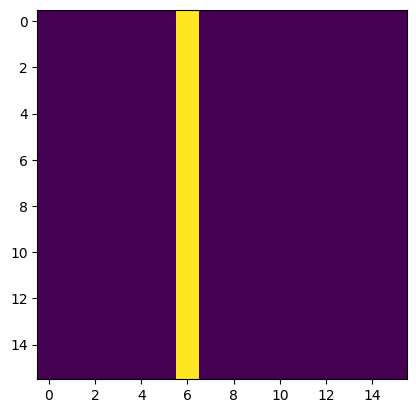

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    plt.imshow(attention, interpolation='nearest')
    plt.show()


In [ ]:
attention

tensor([[4.1652e-05, 1.8743e-08, 4.3531e-15, 1.3554e-17, 2.0464e-16, 1.3552e-08,
         9.9992e-01, 1.8685e-20, 2.9881e-23, 3.2375e-22, 4.0948e-22, 5.8909e-23,
         5.1022e-18, 4.1652e-05, 1.0425e-15, 3.1295e-16],
        [6.9659e-16, 5.0016e-07, 1.9475e-12, 6.0816e-15, 4.3889e-14, 1.0717e-07,
         1.0000e+00, 1.2967e-17, 1.6856e-19, 1.3311e-18, 2.6679e-18, 2.0186e-19,
         6.4972e-16, 6.9659e-16, 3.3120e-14, 1.4395e-14],
        [2.8160e-17, 4.6376e-12, 3.3828e-09, 3.1156e-10, 7.6270e-09, 3.4791e-07,
         1.0000e+00, 1.6709e-13, 7.2155e-15, 7.7347e-15, 2.2479e-14, 1.4072e-14,
         3.9355e-12, 2.8160e-17, 7.8200e-14, 8.5553e-14],
        [8.9966e-22, 3.2495e-17, 1.8656e-13, 6.4120e-14, 1.5420e-11, 2.0936e-09,
         1.0000e+00, 3.8246e-18, 1.3870e-19, 3.8302e-19, 3.0957e-18, 2.5225e-19,
         1.7452e-17, 8.9966e-22, 3.4182e-18, 3.9053e-18],
        [1.0318e-33, 1.2762e-28, 2.2427e-30, 7.8236e-32, 1.9107e-27, 3.6965e-22,
         1.0000e+00, 3.1281e-36, 1.3927